<a href="https://colab.research.google.com/github/SarahXia0405/food-nutrition-app/blob/main/Final_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Final Project - Stock Price Forecasting

### Group Baharat: Sarah Xia, Yunlei Xu, Terry Zhuang, Yi Yao
### Date: Wednesday March 12th, 2025

### Part 1: Problem Statement

#### 1.1 Business Problem

The modern financial landscape is characterized by rapid market shifts and inherent uncertainty, making accurate stock price forecasting a critical tool for investors, portfolio managers, and financial analysts. This project aims to address the challenge of predicting future stock prices and volatility by leveraging over a decade of historical data across four key sectors:

* Technology: Apple Inc. (AAPL)
* Healthcare: Johnson & Johnson (JNJ)
* Finance: JPMorgan Chase (JPM)
* Energy: ExxonMobil (XOM)

By constructing robust time series models, the project seeks to deliver actionable insights that can forecast stock trends over the next year (252 trading days). The resulting forecasts and model evaluations are expected to support strategic decision-making, optimize portfolio allocation, and manage financial risks in an ever-changing market environment.


#### 1.2 Data Extraction

Instead of seeking for a dataset that potentially has the desired company selection and alongside their daily stock trading close price at the time horizon that we wanted to fit and predict on for, we decided to extract the data ourselves through yahoo finance's package ```yfinance```

**Please see below for detailed documented data extraction and transformation process.** One thing to note is, this data was extracted on January 15, 2025. By then, the ```yfinance``` packages did not went through their latest updates, which later when we returned and tried to extract more data, it only returns error message "Too Many Requests. Rate limited" and wouldn't allow me to access more data. There were probably incompatibility issues.

**This is only a demonstration of our data extraction process, even if the yfinance commands doesn't run due to the above mentioned issues, it wouldn't prevent the rest of our modeling codes to work, they are separated processes**

- Documentation for yfinance package: https://aroussi.com/post/python-yahoo-finance
- I have selected the top 50 companies ranked by market capitalization as the 50 companies, based on this list: https://stockanalysis.com/list/sp-500-stocks/

In [ ]:
import pandas as pd
import warnings
import yfinance as yf
warnings.filterwarnings('ignore')
sp500_data = pd.read_csv("sp-500-stocks-stocks.csv")

In [ ]:
# Extracting comp_tickers from S&P 500 Companies ranked by market capitalization
sp500_comp_ticker = []
for line in sp500_data['Symbol']:
    sp500_comp_ticker.append(line)
top50_comp_ticker = []
for i in range(51):
    top50_comp_ticker.append(sp500_comp_ticker[i])
top50_comp_ticker.pop(top50_comp_ticker.index('BRK.B'))
ticker_search_string = ""
for ticker in top50_comp_ticker:
    ticker_search_string += str(ticker)
    ticker_search_string += " "
ticker_search_string

In [ ]:
# Getting historical price using yfinance package
historical_pdata = yf.download(ticker_search_string, start="2010-01-01", end="2025-01-15", group_by="ticker")

historical_pdata = historical_pdata.reset_index()
historical_pdata.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in historical_pdata.columns]

# due to the format of this data, num of price data should be calculated otherwise
50*3782
# Checked with the flattened dataframe, the number matched.

In [ ]:
# Melt and Flatten the downloaded dataset for easier operation, final dataframe variable name: hist_p_df
df_reset = historical_pdata.reset_index()
melted_df = pd.melt(
    df_reset,
    id_vars=["Date"],  # 'Date__' as shown in the screenshot
    var_name="Ticker_Variable",
    value_name="Value"
)

# Split the 'Ticker_Variable' column into 'Ticker' and 'Variable' (e.g., NOW_Open -> Ticker: NOW, Variable: Open)
melted_df[['Ticker', 'Variable']] = melted_df['Ticker_Variable'].str.split('_', expand=True)

# Drop the original 'Ticker_Variable' column
melted_df.drop(columns=["Ticker_Variable"], inplace=True)

In [ ]:
melted_df = melted_df.sort_values(by=["Date", "Ticker"])

# Initialize an empty dictionary to build the new data
data_dict = {
    "Date": [],
    "Ticker": [],
    "Open": [],
    "High": [],
    "Low": [],
    "Close": [],
    "Volume": [],
}

# Iterate through the DataFrame and populate the dictionary
for _, row in melted_df.iterrows():
    date = row["Date"]
    ticker = row["Ticker"]
    variable = row["Variable"]
    value = row["Value"]

    # Check if the date and ticker combination already exists
    if len(data_dict["Date"]) == 0 or (data_dict["Date"][-1] != date or data_dict["Ticker"][-1] != ticker):
        # Append a new row
        data_dict["Date"].append(date)
        data_dict["Ticker"].append(ticker)
        data_dict["Open"].append(None)
        data_dict["High"].append(None)
        data_dict["Low"].append(None)
        data_dict["Close"].append(None)
        data_dict["Volume"].append(None)

    # Assign the value to the correct column
    if variable in data_dict:
        data_dict[variable][-1] = value

# Convert the dictionary back into a DataFrame
flattened_df = pd.DataFrame(data_dict)

# Sort the final DataFrame by Date and Ticker
flattened_df = flattened_df.sort_values(by=["Date", "Ticker"])

# Display the final DataFrame
print(flattened_df)

In [ ]:
flattened_df = flattened_df[flattened_df['Ticker']!= 'index']

In [ ]:
hist_p_df = flattened_df.copy()

In [ ]:
# exporting dataset
# Open a file and write the data row by row
with open('top50_comp_histp_since2010.csv', 'w') as f:
    # Write the header
    f.write(','.join(map(str, flattened_df.columns)) + '\n')

    # Write each row of the DataFrame
    for _, row in flattened_df.iterrows():
        f.write(','.join(map(str, row)) + '\n')

print("Dataset saved as 'top50_comp_histp_since2010.csv'")

#### 1.3 Hypotheses and Assumptions

* Predictability of Historical Trends: Historical stock price movements and volatility patterns contain sufficient information to reliably forecast future trends for the selected stocks.

* Data Quality and Consistency:
The historical stock price data sourced from Yahoo Finance is accurate, consistent, and representative of the true market behavior over the period from 2010-01-05 to 2025-01-14.

* Stability of Market Conditions:
The underlying market conditions, including investor sentiment and macroeconomic influences, are assumed to remain relatively stable during the forecast period. Any major disruptive events are beyond the scope of this analysis.

### Part 2: Data Loading & Structure Inspection

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

# Load dataset
file_path = "/content/drive/MyDrive/UChi/Time Series Final Project/Finance dataset/top50_comp_histp_since2010.csv"
df = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")

# Display first few rows
print(df.head())

# Check for missing values only for the selected stocks
stocks = ["AAPL", "JNJ", "JPM", "XOM"]
df_stocks = df[df["Ticker"].isin(stocks)]  # Filter only the selected stocks

# Check for missing values
missing_values = df_stocks.isnull().sum()
print(missing_values)

# Convert to datetime index and check the date range
df_stocks.index = pd.to_datetime(df_stocks.index)
print(f"Data from {df_stocks.index.min()} to {df_stocks.index.max()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
           Ticker       Open       High        Low      Close       Volume
Date                                                                      
2010-01-04   AAPL   6.429938   6.462174   6.398305   6.447412  493729600.0
2010-01-04   ABBV        NaN        NaN        NaN        NaN          NaN
2010-01-04    ABT  18.573216  18.700031  18.480675  18.665756   10829095.0
2010-01-04    ACN  31.524199  32.040491  31.509014  31.941788    3650100.0
2010-01-04   ADBE  36.650002  37.299999  36.650002  37.090000    4710200.0
Ticker    0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
Data from 2010-01-04 00:00:00 to 2025-01-14 00:00:00


In [ ]:
df_stocks

,Ticker,Open,High,Low,Close,Volume
Date,,,,,,
2010-01-04,AAPL,6.429938,6.462174,6.398305,6.447412,493729600.0
2010-01-04,JNJ,41.675017,41.855344,41.481812,41.655697,9506200.0
2010-01-04,JPM,28.289197,29.101522,28.207962,29.006748,35460500.0
2010-01-04,XOM,39.027905,39.334586,38.726905,39.272114,27809100.0
2010-01-05,AAPL,6.465188,6.495014,6.424517,6.458560,601904800.0
...,...,...,...,...,...,...
2025-01-13,XOM,107.129997,109.629997,107.129997,109.290001,17073400.0
2025-01-14,AAPL,234.750000,236.119995,232.470001,233.279999,39435300.0
2025-01-14,JNJ,144.500000,144.809998,142.860001,144.750000,8681700.0


### Part 3: Exploratory Data Analysis

#### 3.1 Stock Price Visualization

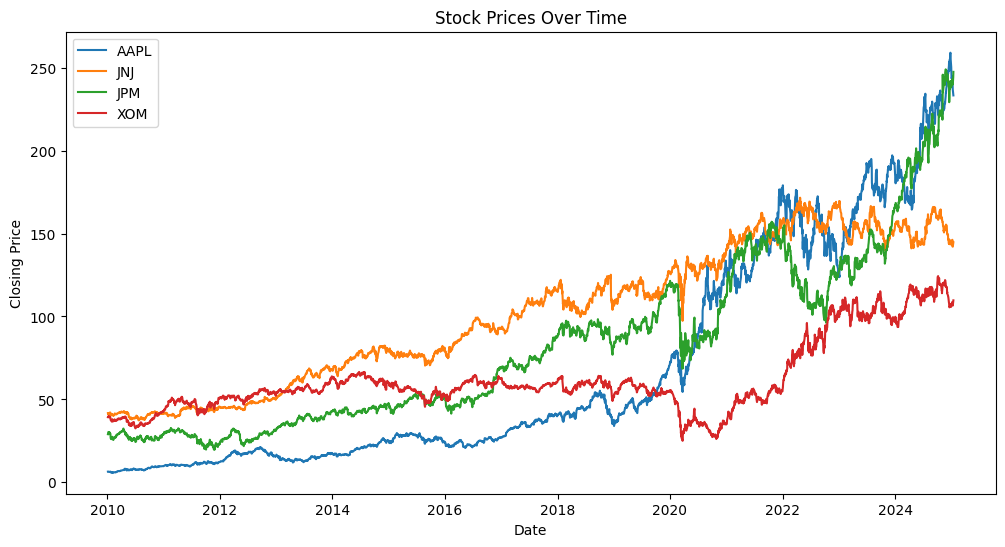

In [ ]:
import matplotlib.pyplot as plt

# Plot stock price trends for all four stocks
plt.figure(figsize=(12,6))
for stock in stocks:
    stock_data = df_stocks[df_stocks["Ticker"] == stock]["Close"]
    plt.plot(stock_data, label=stock)

plt.legend()
plt.title("Stock Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.show()

#### 3.2 ACF & PACF

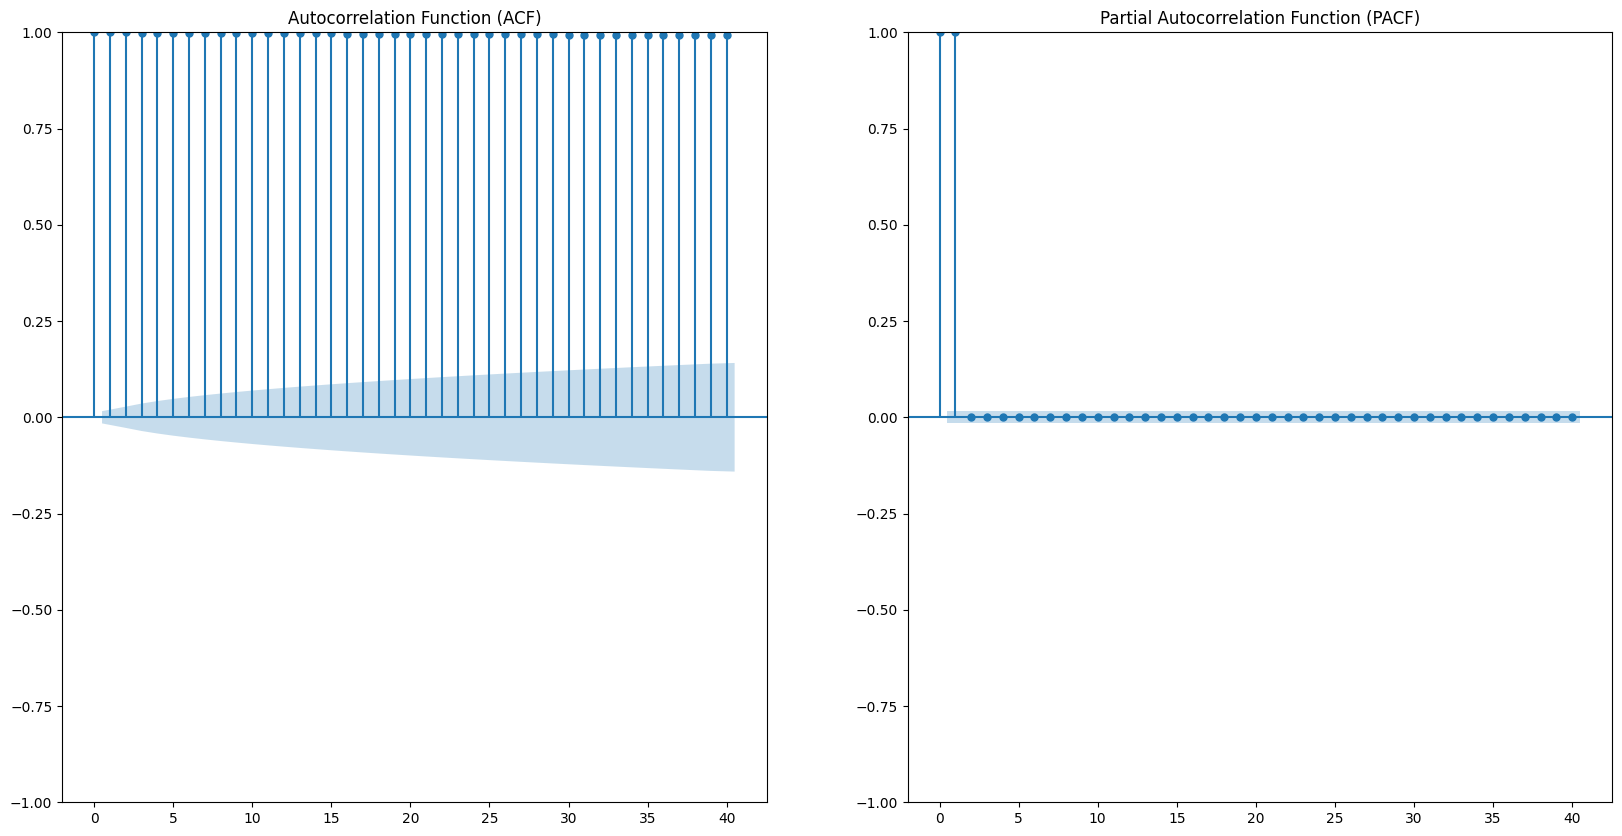

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Set plot size
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Plot ACF (Autocorrelation)
plot_acf(df_stocks["Date"], lags=40, ax=ax[0])
ax[0].set_title("Autocorrelation Function (ACF)")

# Plot PACF (Partial Autocorrelation)
plot_pacf(df_stocks["Date"], lags=40, ax=ax[1])
ax[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()

#### 3.3 Stationarity Check

In [ ]:
# Check for stationarity
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, stock_name):
    """Perform ADF test and print results."""
    result = adfuller(series.dropna())
    print(f"ADF Statistic for {stock_name}: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print(f"{stock_name} is stationary.\n")
    else:
        print(f"{stock_name} is NOT stationary. Differencing is required.\n")

# Apply ADF test to each stock's closing price
for stock in stocks:
    stock_data = df_stocks[df_stocks["Ticker"] == stock]["Close"]
    check_stationarity(stock_data, stock)

ADF Statistic for AAPL: 1.164638714914192
p-value: 0.99573222848956
AAPL is NOT stationary. Differencing is required.

ADF Statistic for JNJ: -1.1097416123950492
p-value: 0.7111714685984856
JNJ is NOT stationary. Differencing is required.

ADF Statistic for JPM: 1.8888075927673487
p-value: 0.9985097979011422
JPM is NOT stationary. Differencing is required.

ADF Statistic for XOM: -0.32356565279576616
p-value: 0.9220997826498186
XOM is NOT stationary. Differencing is required.



In [ ]:
# Apply first-order differencing for non-stationary series and drop NaN values
df_stocks["Close_Diff"] = df_stocks.groupby("Ticker")["Close"].diff()
df_stocks = df_stocks.dropna(subset=["Close_Diff"])

# Check stationarity again after differencing
for stock in stocks:
    stock_data_diff = df_stocks[df_stocks["Ticker"] == stock]["Close_Diff"]
    check_stationarity(stock_data_diff.dropna(), f"{stock} (Differenced)")

<ipython-input-5-5ec87de44720>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stocks["Close_Diff"] = df_stocks.groupby("Ticker")["Close"].diff()


ADF Statistic for AAPL (Differenced): -14.131655512127539
p-value: 2.3279700455550943e-26
AAPL (Differenced) is stationary.

ADF Statistic for JNJ (Differenced): -15.845506872061478
p-value: 9.58216869417386e-29
JNJ (Differenced) is stationary.

ADF Statistic for JPM (Differenced): -17.740653418706888
p-value: 3.40333430651668e-30
JPM (Differenced) is stationary.

ADF Statistic for XOM (Differenced): -12.530200002099312
p-value: 2.4381502248012166e-23
XOM (Differenced) is stationary.



#### 3.4 Trend Check

In [ ]:
import seaborn as sns
from scipy.stats import kendalltau

# Compute Mann-Kendall trend test for each stock's closing prices
trend_results = {}
for ticker in stocks:
    tau, p_value = kendalltau(range(len(prices_df[ticker].dropna())), prices_df[ticker].dropna())
    trend_results[ticker] = {"Kendall Tau": tau, "p-value": p_value}

# Convert results into a DataFrame
trend_df = pd.DataFrame.from_dict(trend_results, orient='index')

# Display trend test results
print("Mann-Kendall Trend Test Results")
print(trend_df)

Mann-Kendall Trend Test Results
      Kendall Tau  p-value
AAPL     0.906588      0.0
JNJ      0.872566      0.0
JPM      0.858521      0.0
XOM      0.436692      0.0


The stock returns are already stationary and we used returns (Price changes) instead of raw prices to detrend. No further transformations are needed.

### Part 4: Model Development & Evaluation

In [ ]:
# Split data into train and test data sets
train_start_date, train_end_date = "2010-01-05", "2024-01-12"
test_start_date, test_end_date = "2024-01-16", "2025-01-14"
forecast_start_date, forecast_end_date = "2025-01-15", "2026-01-01"

stocks = ["AAPL", "JNJ", "JPM", "XOM"]
evaluation_results = {}
gap_days = 3  # The missing days (1/13, 1/14, 1/15) between train & test

#### 4.1 ARIMA (AutoRegressive Integrated Moving Average) Model

##### 4.1.1 Fit ARIMA models to training data set. Apply the models to test data set and choose the best ARIMA model based on metrics like RMSE, MAE, etc.

In [ ]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

def mean_absolute_percentage_error(y_true, y_pred):
    """
    Compute MAPE: mean absolute percentage error.
    Returns a percentage; e.g., 5.0 = 5%.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_idx = (y_true != 0)
    if len(y_true[non_zero_idx]) == 0:
        return np.nan
    return np.mean(np.abs((y_true[non_zero_idx] - y_pred[non_zero_idx]) / y_true[non_zero_idx])) * 100

for stock in stocks:
    print(f"\n=== Stock: {stock} ===")

    # Subset & sort
    stock_data = df_stocks[df_stocks["Ticker"] == stock].sort_index().copy()
    if stock_data.empty:
        print(f"No data for {stock}, skipping.")
        continue

    # Train & test sets
    train_data = stock_data.loc[stock_data.index <= train_end_date, "Close"].dropna()
    test_data  = stock_data.loc[(stock_data.index >= test_start_date) &
                                (stock_data.index <= test_end_date), "Close"].dropna()

    if len(train_data) == 0 or len(test_data) == 0:
        print(f"Skipping {stock}: Not enough train or test data.")
        continue

    print(f"Train range: {train_data.index.min()} to {train_data.index.max()} (rows={len(train_data)})")
    print(f"Test  range: {test_data.index.min()} to {test_data.index.max()} (rows={len(test_data)})")

    # Fit auto_arima on train
    model = auto_arima(
        train_data,
        start_p=0, max_p=5,
        start_q=0, max_q=5,
        seasonal=False,
        stepwise=True,
        trace=False
    )
    print(f"\nBest model for {stock}: ARIMA{model.order}, AIC={model.aic():.2f}")

    # We ask for extra steps = gap_days + length of test_data
    # So the first 'gap_days' forecasts correspond to 1/13-1/15 (which don't exist),
    # and the remaining forecasts align with 1/16 ~ test_end_date.
    needed_steps = gap_days + len(test_data)
    full_forecast = model.predict(n_periods=needed_steps)

    # Skip the first gap_days. The rest (last len(test_data)) are the real test forecasts.
    usable_forecast = full_forecast[gap_days:]

    # Convert usable_forecast to a numpy array so that the new index is assigned by order.
    forecast_series = pd.Series(usable_forecast.values, index=test_data.index)

    # Clean any leftover NaNs
    forecast_series.dropna(inplace=True)
    test_data_aligned = test_data.loc[forecast_series.index].dropna()

    if len(forecast_series) == 0 or len(test_data_aligned) == 0:
        print(f"Skipping {stock}: No overlapping data after final alignment.")
        continue

    # Trim if lengths differ
    min_len = min(len(forecast_series), len(test_data_aligned))
    forecast_series = forecast_series.iloc[:min_len]
    test_data_aligned = test_data_aligned.iloc[:min_len]

    # Evaluate
    mse = mean_squared_error(test_data_aligned.values, forecast_series.values)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(test_data_aligned.values, forecast_series.values)
    mape = mean_absolute_percentage_error(test_data_aligned.values, forecast_series.values)

    n = len(model.resid())  # Sample size
    k = len(model.params())  # Number of estimated parameters

    if (n - k - 1) > 0:
        aicc = model.aic() + (2 * k * (k + 1)) / (n - k - 1)
    else:
        aicc = np.nan

    evaluation_results[stock] = {
        "ARIMA Order": model.order,
        "AIC": model.aic(),
        "AICc": aicc,
        "BIC": model.bic(),
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape
    }
    print(f"\n{stock} Test RMSE : {rmse:.4f}")
    print(f"{stock} Test MAE  : {mae:.4f}")
    print(f"{stock} Test MAPE : {mape:.2f}%")

# Print final evaluation results
print("\n=== Final Evaluation Results ===")
for st, metrics in evaluation_results.items():
    print(f"\n--- {st} ---")
    for k, v in metrics.items():
        if isinstance(v, float):
            print(f"{k}: {v:.4f}")
        else:
            print(f"{k}: {v}")




=== Stock: AAPL ===
Train range: 2010-01-05 00:00:00 to 2024-01-12 00:00:00 (rows=3530)
Test  range: 2024-01-16 00:00:00 to 2025-01-14 00:00:00 (rows=251)

Best model for AAPL: ARIMA(0, 1, 1), AIC=12627.40

AAPL Test RMSE : 28.4649
AAPL Test MAE  : 24.1585
AAPL Test MAPE : 11.02%

=== Stock: JNJ ===
Train range: 2010-01-05 00:00:00 to 2024-01-12 00:00:00 (rows=3530)
Test  range: 2024-01-16 00:00:00 to 2025-01-14 00:00:00 (rows=251)

Best model for JNJ: ARIMA(4, 1, 1), AIC=11114.94

JNJ Test RMSE : 11.2708
JNJ Test MAE  : 9.1614
JNJ Test MAPE : 6.19%

=== Stock: JPM ===
Train range: 2010-01-05 00:00:00 to 2024-01-12 00:00:00 (rows=3530)
Test  range: 2024-01-16 00:00:00 to 2025-01-14 00:00:00 (rows=251)

Best model for JPM: ARIMA(2, 1, 0), AIC=12178.29

JPM Test RMSE : 40.0101
JPM Test MAE  : 34.9032
JPM Test MAPE : 16.20%

=== Stock: XOM ===
Train range: 2010-01-05 00:00:00 to 2024-01-12 00:00:00 (rows=3530)
Test  range: 2024-01-16 00:00:00 to 2025-01-14 00:00:00 (rows=251)

Best model

##### 4.1.2 Apply the best ARIMA model to the full data set (train + test). Generate a 1-year forecast (252 business days) and plot the results.


=== Processing Forecast for AAPL ===

Forecast for AAPL:
2025-01-15    233.289775
2025-01-16    233.289775
2025-01-17    233.289775
2025-01-20    233.289775
2025-01-21    233.289775
Freq: B, dtype: float64
2025-12-26    233.289775
2025-12-29    233.289775
2025-12-30    233.289775
2025-12-31    233.289775
2026-01-01    233.289775
Freq: B, dtype: float64


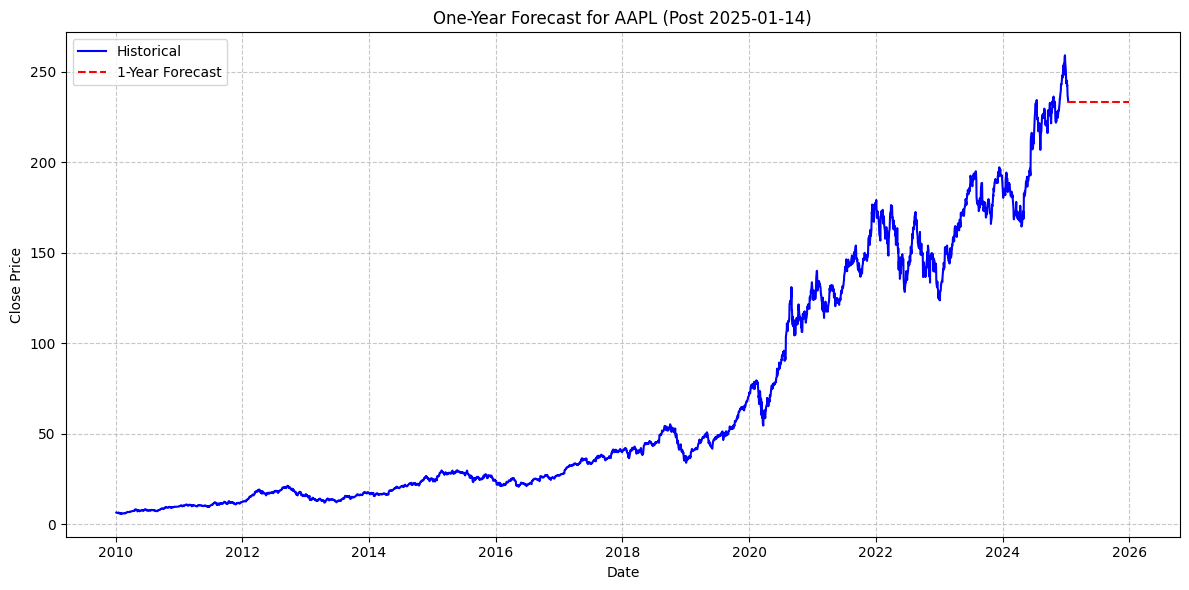

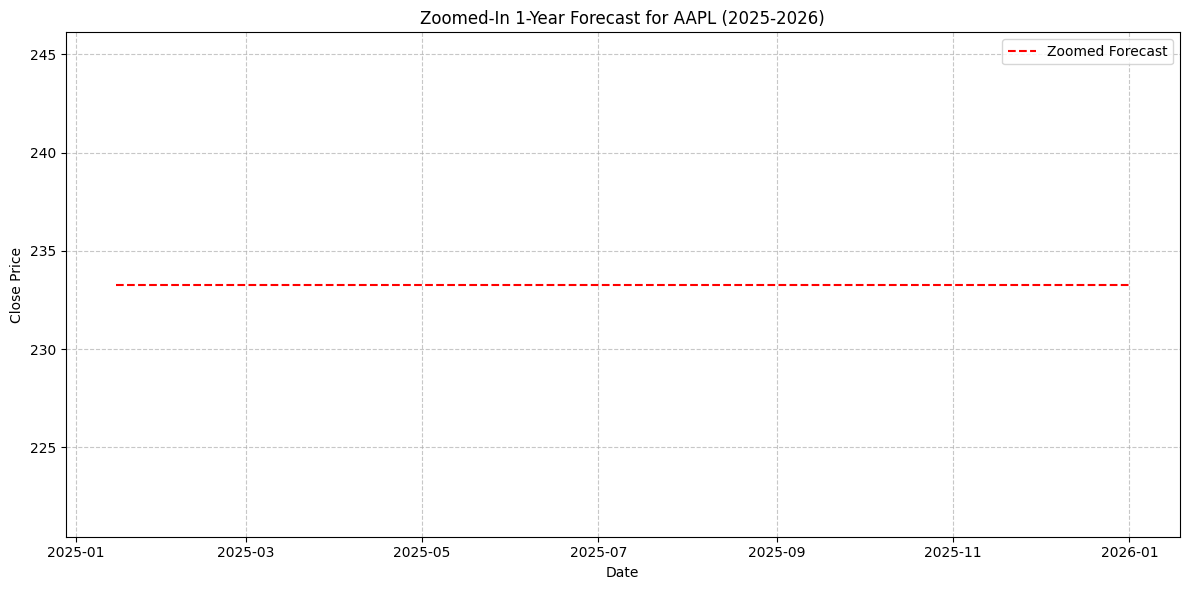


=== Processing Forecast for JNJ ===

Forecast for JNJ:
2025-01-15    145.093645
2025-01-16    144.805810
2025-01-17    144.890941
2025-01-20    144.810561
2025-01-21    144.855575
Freq: B, dtype: float64
2025-12-26    144.84387
2025-12-29    144.84387
2025-12-30    144.84387
2025-12-31    144.84387
2026-01-01    144.84387
Freq: B, dtype: float64


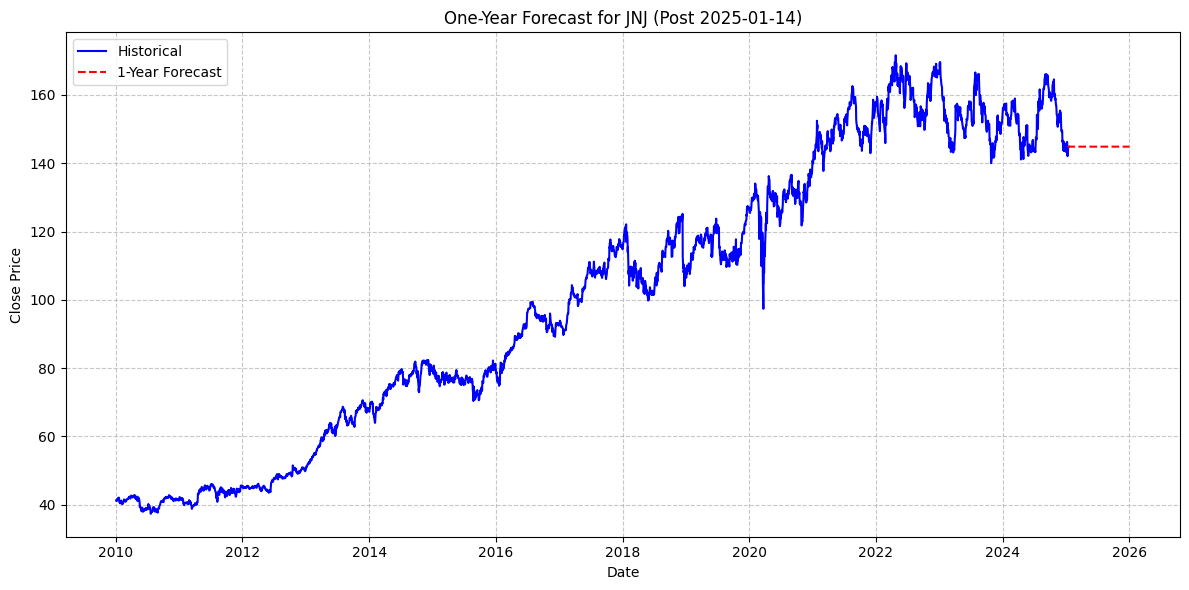

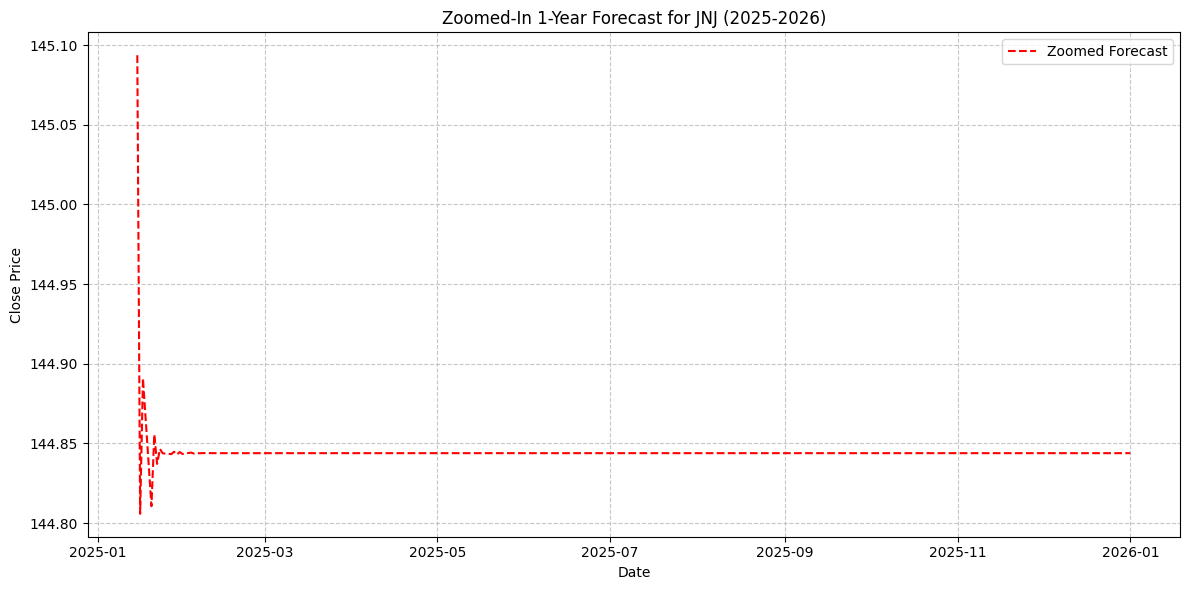


=== Processing Forecast for JPM ===

Forecast for JPM:
2025-01-15    247.461646
2025-01-16    247.613858
2025-01-17    247.603651
2025-01-20    247.611391
2025-01-21    247.610417
Freq: B, dtype: float64
2025-12-26    247.610788
2025-12-29    247.610788
2025-12-30    247.610788
2025-12-31    247.610788
2026-01-01    247.610788
Freq: B, dtype: float64


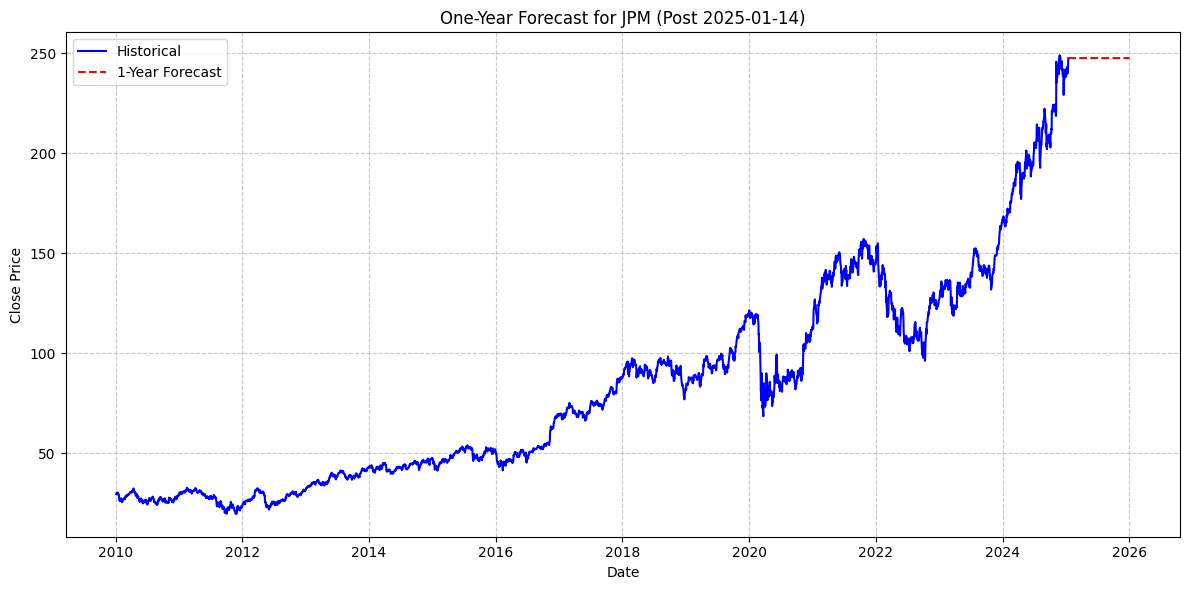

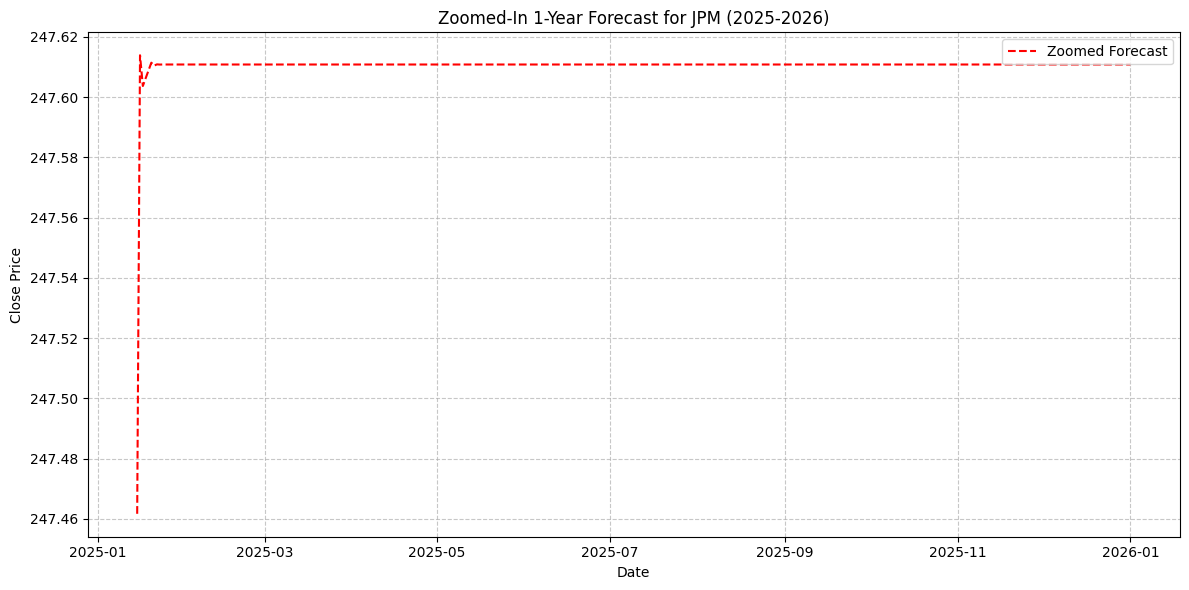


=== Processing Forecast for XOM ===

Forecast for XOM:
2025-01-15    109.720001
2025-01-16    109.720001
2025-01-17    109.720001
2025-01-20    109.720001
2025-01-21    109.720001
Freq: B, dtype: float64
2025-12-26    109.720001
2025-12-29    109.720001
2025-12-30    109.720001
2025-12-31    109.720001
2026-01-01    109.720001
Freq: B, dtype: float64


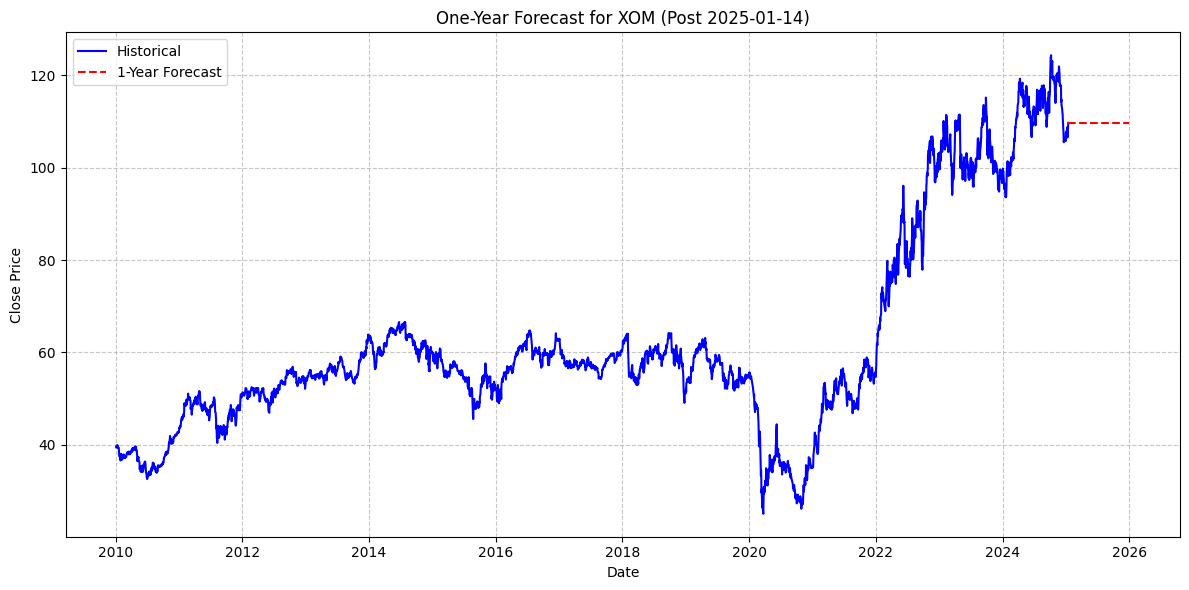

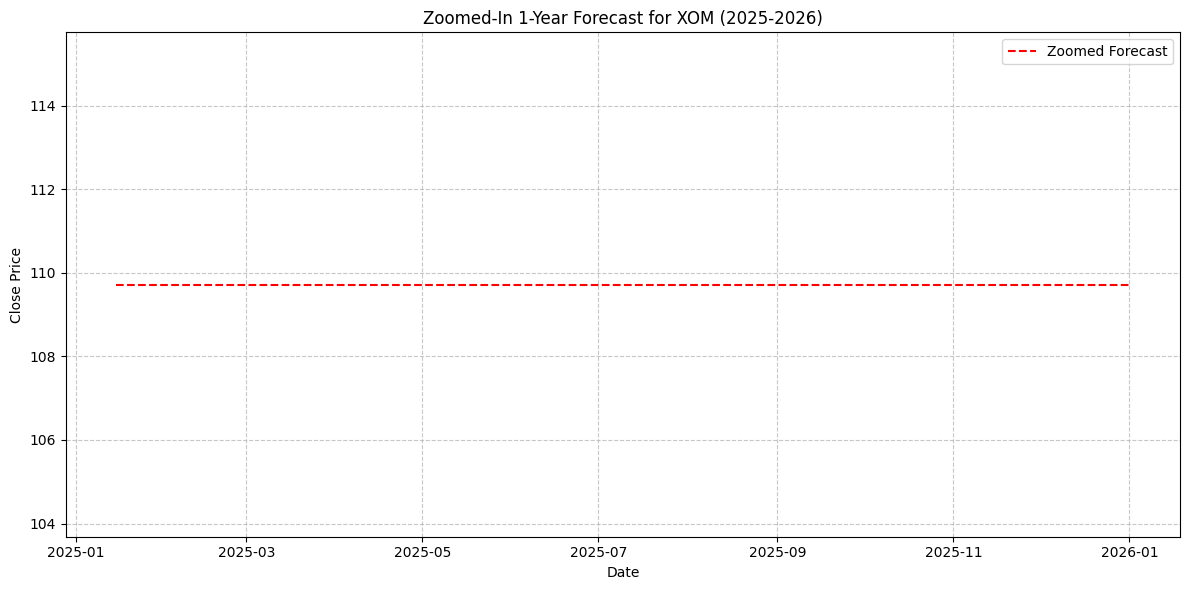

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Store the best ARIMA orders from evaluation
best_arima_orders = {
    "AAPL": (0, 1, 1),
    "JNJ": (4, 1, 1),
    "JPM": (2, 1, 0),
    "XOM": (0, 1, 0)
}

# Define the forecast period (252 business days ~ 1 year)
future_horizon = 252
future_start_date = pd.to_datetime("2025-01-15")

for stock in best_arima_orders.keys():
    print(f"\n=== Processing Forecast for {stock} ===")

    # Subset and sort full historical data
    stock_data = df_stocks[df_stocks["Ticker"] == stock].sort_index().copy()
    if stock_data.empty:
        print(f"No historical data for {stock}. Skipping forecast.")
        continue

    # Use 'Close' prices for forecasting
    full_data = stock_data["Close"].dropna()
    if full_data.empty:
        print(f"No close price data for {stock}. Skipping forecast.")
        continue

    # Get the best ARIMA order from previous evaluation
    order = best_arima_orders[stock]

    # Ensure no NaNs before fitting
    full_data = full_data.dropna()

    try:
        # Refit ARIMA on the entire dataset
        model_full = ARIMA(full_data, order=order).fit()
    except Exception as e:
        print(f"Error fitting ARIMA model for {stock}: {e}")
        continue

    try:
        # Generate forecast using `.get_forecast()` to include confidence intervals
        future_pred = model_full.predict(start=len(full_data), end=len(full_data) + future_horizon - 1)
    except Exception as e:
        print(f"Error generating forecast for {stock}: {e}")
        continue

    # Create DatetimeIndex for future forecast
    future_dates = pd.date_range(start=future_start_date, periods=future_horizon, freq="B")

    # Convert predictions to Series
    future_forecast = pd.Series(future_pred.values, index=future_dates)

    # Debug: Check forecast values
    print(f"\nForecast for {stock}:")
    print(future_forecast.head())  # Print first few forecasted values
    print(future_forecast.tail())  # Print last few forecasted values

    # Check if forecast contains NaNs
    if future_forecast.isnull().all():
        print(f"ERROR: Forecast for {stock} contains only NaNs. Skipping plot.")
        continue

    # === Plot 1: Full Historical Data + Forecast ===
    plt.figure(figsize=(12, 6))
    plt.plot(full_data.index, full_data, label="Historical", color="blue")
    plt.plot(future_forecast.index, future_forecast, label="1-Year Forecast", linestyle="--", color="red")
    plt.title(f"One-Year Forecast for {stock} (Post 2025-01-14)")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

    # === Plot 2: Zoomed-In Forecast Only ===
    plt.figure(figsize=(12, 6))
    plt.plot(future_forecast.index, future_forecast, label="Zoomed Forecast", linestyle="--", color="red")
    plt.title(f"Zoomed-In 1-Year Forecast for {stock} (2025-2026)")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


#### **Findings**

The ARIMA forecast appears flat for most of the period because ARIMA assumes a stationary process once differencing has been applied. The initial jump at the start of the forecast is likely due to the model adjusting from the last observed value, but after that, it predicts a nearly constant value.

ARIMA models don’t capture long-term trends well. If the data has a strong trend, differencing removes it, and ARIMA can't extrapolate a new trend.

#### 4.2 VAR (Vector AutoRegression) Model

In [ ]:
# Sort data by date
df_stocks = df_stocks.sort_values(by=['Date', 'Ticker'])

# Pivot table to get closing prices of selected stocks
prices_df = df_stocks.pivot(index='Date', columns='Ticker', values='Close')

train_data = prices_df.loc[train_start:train_end]
test_data = prices_df.loc[test_start:test_end]

# Compute daily returns
returns_df = prices_df.pct_change().dropna()

# Split returns into training and testing
train_returns = returns_df.loc[train_start:train_end]
test_returns = returns_df.loc[test_start:test_end]

##### 4.2.1 Determine Optimal Lag Order

In [ ]:
# Fit a preliminary VAR model to determine the optimal lag order
model = VAR(train_returns)

# Select the best lag order using AIC and BIC (testing up to 10 lags)
lag_selection = model.select_order(maxlags=10)

# Extract the best lag order based on AIC and BIC
optimal_lag_aic = lag_selection.aic
optimal_lag_bic = lag_selection.bic

# Display the optimal lag order based on AIC and BIC
optimal_lag_aic, optimal_lag_bic


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


(9, 0)

Since AIC generally performs better for time series forecasting, we will use 9 lags for the VAR model.

##### 4.2.2 Fit VAR Model and Forecast Returns for Test Period (2024-2025)

In [ ]:
# Fit the VAR model using the optimal lag (AIC: 9)
model_fitted = model.fit(optimal_lag_aic)

# Forecast returns for the test period (2024-2025)
n_forecast = len(test_returns)
forecast_input = train_returns.values[-optimal_lag_aic:]

# Generate forecasts
forecasted_returns = model_fitted.forecast(y=forecast_input, steps=n_forecast)

# Convert forecasts into a DataFrame with the test date index
forecasted_returns_df = pd.DataFrame(forecasted_returns, index=test_returns.index, columns=test_returns.columns)

# Display forecasted returns
print("Forecasted Stock Returns (2024-2025)")
print(forecasted_returns_df)


Forecasted Stock Returns (2024-2025)
Ticker          AAPL       JNJ       JPM       XOM
Date                                              
2024-01-16  0.000181  0.001419 -0.000323 -0.001113
2024-01-17  0.002491  0.001020 -0.000089 -0.000228
2024-01-18  0.002169 -0.000033  0.001491  0.001225
2024-01-19 -0.002449 -0.000873 -0.001627  0.000061
2024-01-22  0.002151  0.000606  0.003205  0.002197
...              ...       ...       ...       ...
2025-01-07  0.001122  0.000434  0.000644  0.000383
2025-01-08  0.001122  0.000434  0.000644  0.000383
2025-01-10  0.001122  0.000434  0.000644  0.000383
2025-01-13  0.001122  0.000434  0.000644  0.000383
2025-01-14  0.001122  0.000434  0.000644  0.000383

[251 rows x 4 columns]


##### 4.2.3 Convert Returns to Prices

In [ ]:
# Use the last known actual price from the training data as the starting point
last_train_prices = train_data.iloc[-1]

# Reconstruct stock prices using cumulative returns
forecasted_prices = last_train_prices * (1 + forecasted_returns_df).cumprod()

# Display forecasted stock prices for the test period
print("Forecasted Stock Prices (2024-2025)")
print(forecasted_prices)

Forecasted Stock Prices (2024-2025)
Ticker            AAPL         JNJ         JPM         XOM
Date                                                      
2024-01-16  185.047048  157.629981  165.218428   96.545491
2024-01-17  185.507915  157.790779  165.203747   96.523505
2024-01-18  185.910297  157.785547  165.450089   96.641747
2024-01-19  185.455057  157.647828  165.180854   96.647618
2024-01-22  185.854010  157.743285  165.710285   96.859919
...                ...         ...         ...         ...
2025-01-07  243.531902  175.243608  193.841819  106.193149
2025-01-08  243.805046  175.319630  193.966568  106.233792
2025-01-10  244.078497  175.395685  194.091396  106.274450
2025-01-13  244.352254  175.471773  194.216306  106.315124
2025-01-14  244.626318  175.547895  194.341295  106.355813

[251 rows x 4 columns]


##### 4.2.4 Model Evaluation

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create a dictionary to store evaluation results
evaluation_results = {}

# Loop through each stock ticker to calculate error metrics
for ticker in test_data.columns:
    actual_prices = test_data[ticker].dropna()  # Ensure no NaNs in actual data
    predicted_prices = forecasted_prices.loc[actual_prices.index, ticker]  # Align indices

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))

    # Compute MAE
    mae = mean_absolute_error(actual_prices, predicted_prices)

    # Compute MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100

    # Store results in dictionary
    evaluation_results[ticker] = {"RMSE": rmse, "MAE": mae, "MAPE": mape}

# Convert evaluation results into a DataFrame
evaluation_df = pd.DataFrame.from_dict(evaluation_results, orient='index')
evaluation_df

# --- Compute AIC, AICc, and BIC for the VAR Model ---
# Extract AIC and BIC from the fitted model
aic = model_fitted.aic
bic = model_fitted.bic

# Compute Corrected AIC (AICc) using formula
n_obs = train_returns.shape[0]  # Number of observations
k_params = model_fitted.df_model  # Number of estimated parameters
aicc = aic + (2 * k_params * (k_params + 1)) / (n_obs - k_params - 1)  # AICc formula

# Create a DataFrame to display AIC, AICc, and BIC
aic_metrics_df = pd.DataFrame({"AIC": [aic], "AICc": [aicc], "BIC": [bic]})

print(evaluation_df)
print(aic_metrics_df)

           RMSE        MAE       MAPE
AAPL  13.632015  10.316012   5.398164
JNJ   15.908909  13.737887   9.195193
JPM   29.335872  25.530465  11.856959
XOM   12.078750  10.800297   9.407445
         AIC       AICc        BIC
0 -34.404422 -33.599153 -34.145223


##### 4.2.5 Forecast Future Stock Prices (2025-2026)

In [ ]:
# Forecast stock returns for 2025-2026 (252 trading days)
n_future_days = 252

# Use the last known returns from the test set as the starting point
forecast_input = test_returns.values[-optimal_lag_aic:]

# Generate future forecasts
future_forecasted_returns = model_fitted.forecast(y=forecast_input, steps=n_future_days)

# Convert future forecasts into a DataFrame with future date index
future_dates = pd.date_range(start=test_returns.index[-1] + pd.Timedelta(days=1), periods=n_future_days, freq='B')  # Business days
future_forecasted_returns_df = pd.DataFrame(future_forecasted_returns, index=future_dates, columns=test_returns.columns)

# Convert forecasted returns back to stock prices
last_test_prices = test_data.iloc[-1]
future_forecasted_prices = last_test_prices * (1 + future_forecasted_returns_df).cumprod()

# Display the forecasted stock prices for 2025-2026
print("Forecasted Stock Prices (2025-2026)")
print(future_forecasted_prices)

Forecasted Stock Prices (2025-2026)
Ticker            AAPL         JNJ         JPM         XOM
2025-01-15  234.998835  145.189062  248.181783  110.280395
2025-01-16  235.391970  145.271358  248.760762  110.216420
2025-01-17  235.263669  145.179665  248.104757  110.096632
2025-01-20  235.770774  145.326925  248.379536  110.237320
2025-01-21  235.725571  145.277589  248.353343  110.568703
...                ...         ...         ...         ...
2025-12-26  309.511243  161.722239  290.564894  121.222455
2025-12-29  309.858389  161.792395  290.751890  121.268850
2025-12-30  310.205925  161.862582  290.939005  121.315262
2025-12-31  310.553850  161.932799  291.126242  121.361692
2026-01-01  310.902165  162.003047  291.313598  121.408140

[252 rows x 4 columns]


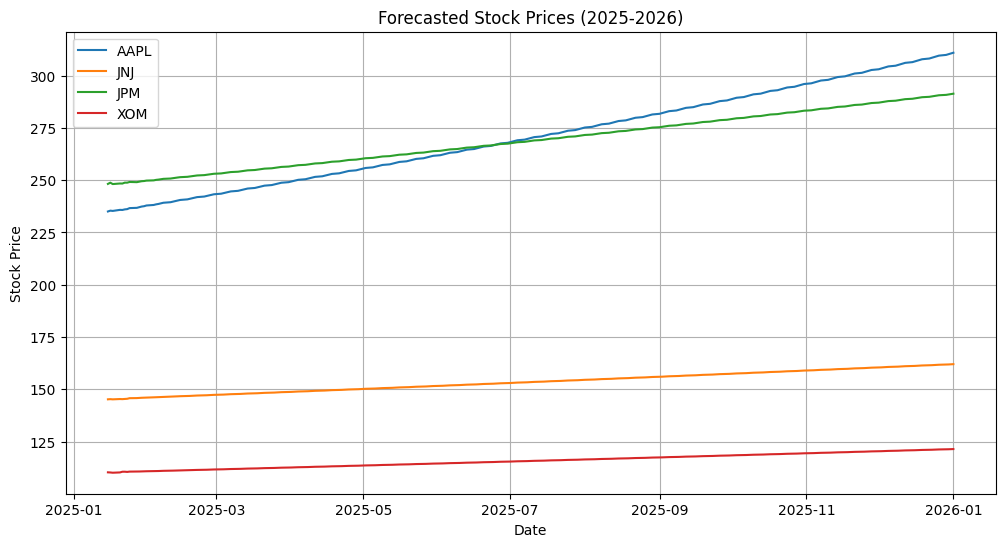

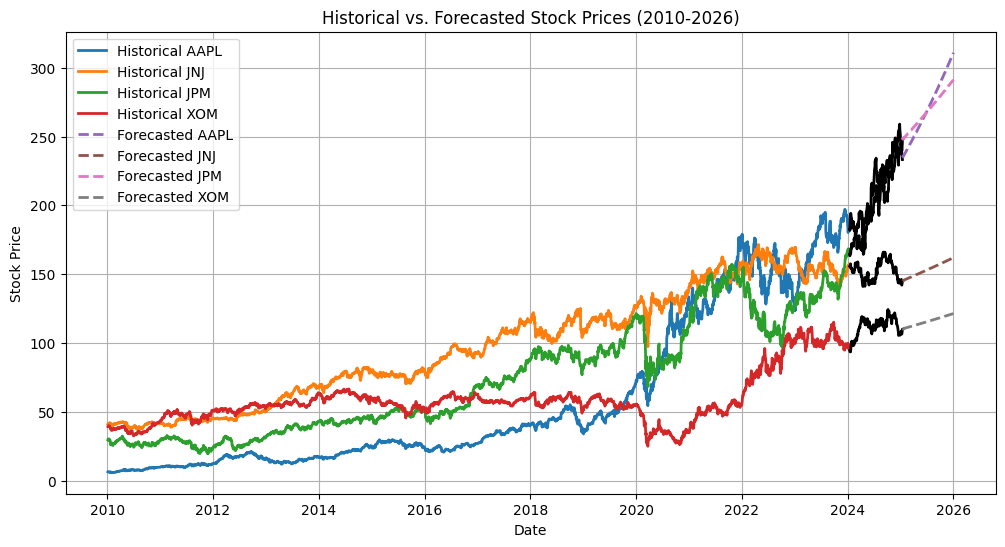

In [ ]:
import matplotlib.pyplot as plt

# Plot forecasted stock prices
plt.figure(figsize=(12, 6))
for ticker in stocks:
    plt.plot(future_forecasted_prices.index, future_forecasted_prices[ticker], label=ticker)
plt.title("Forecasted Stock Prices (2025-2026)")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
# Plot historical stock prices (2010-2025)
for ticker in stocks:
    plt.plot(train_data.index, train_data[ticker], label=f"Historical {ticker}", linestyle='solid', linewidth=2)
    plt.plot(test_data.index, test_data[ticker], linestyle='solid', linewidth=2, color='black')  # Test set

# Plot forecasted stock prices (2025-2026)
for ticker in stocks:
    plt.plot(future_forecasted_prices.index, future_forecasted_prices[ticker], label=f"Forecasted {ticker}", linestyle='dashed', linewidth=2)

plt.title("Historical vs. Forecasted Stock Prices (2010-2026)")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

##### 4.2.6 Compute Confidence Intervals for Forecasts

In [ ]:
import numpy as np

# Compute confidence intervals for 95% confidence level
confidence_level = 1.96

# Get forecast errors from the VAR model
forecast_error_cov = model_fitted.forecast_cov(n_future_days)

# Compute standard deviations for each time step
forecast_std = np.sqrt(np.diagonal(forecast_error_cov, axis1=1, axis2=2))

# Compute confidence intervals
future_returns_upper = future_forecasted_returns_df + (confidence_level * forecast_std)
future_returns_lower = future_forecasted_returns_df - (confidence_level * forecast_std)

# Convert future returns to price confidence intervals
future_prices_upper = last_test_prices * (1 + future_returns_upper).cumprod()
future_prices_lower = last_test_prices * (1 + future_returns_lower).cumprod()

# Display confidence intervals
print("Forecasted Stock Price Upper Bound (95% CI)")
print(future_prices_upper)
print("Forecasted Stock Price Lower Bound (95% CI)")
print(future_prices_lower)

Forecasted Stock Price Upper Bound (95% CI)
Ticker              AAPL           JNJ           JPM            XOM
2025-01-15  2.430368e+02    148.145392  2.565955e+02     113.660186
2025-01-16  2.518458e+02    151.267822  2.659635e+02     117.109164
2025-01-17  2.604234e+02    154.281082  2.743750e+02     120.615359
2025-01-20  2.700081e+02    157.611115  2.840938e+02     124.520777
2025-01-21  2.793250e+02    160.804735  2.938225e+02     128.772438
...                  ...           ...           ...            ...
2025-12-26  1.556025e+06  26994.935975  1.385033e+06  260276.785758
2025-12-29  1.612255e+06  27570.000066  1.434095e+06  268560.306112
2025-12-30  1.670517e+06  28157.314554  1.484895e+06  277107.456237
2025-12-31  1.730884e+06  28757.140407  1.537495e+06  285926.626365
2026-01-01  1.793433e+06  29369.744150  1.591958e+06  295026.473754

[252 rows x 4 columns]
Forecasted Stock Price Lower Bound (95% CI)
Ticker            AAPL         JNJ         JPM         XOM
2025-01-15  2

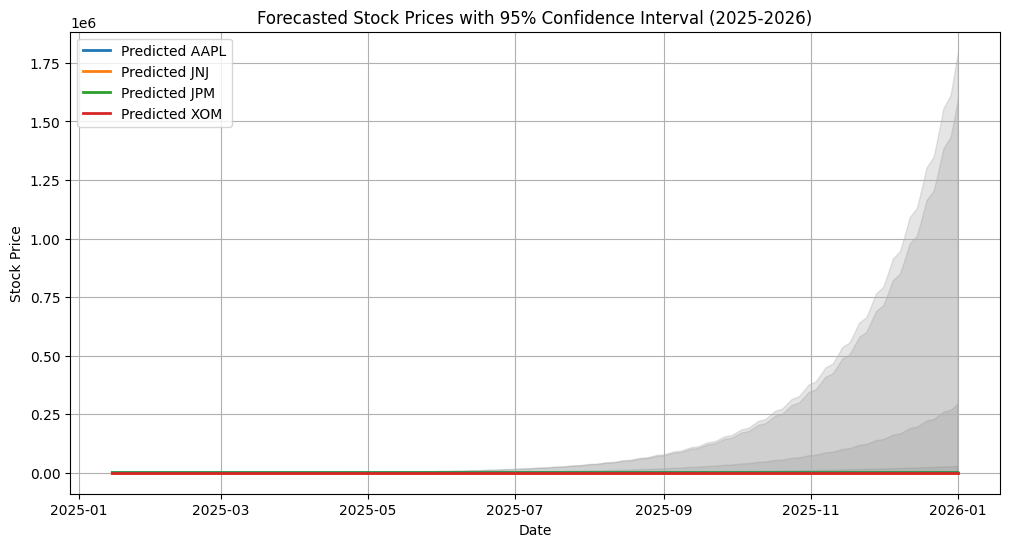

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot each stock's predicted prices with confidence intervals
for ticker in stocks:
    plt.plot(future_forecasted_prices.index, future_forecasted_prices[ticker], label=f"Predicted {ticker}", linewidth=2)
    plt.fill_between(future_forecasted_prices.index,
                     future_prices_lower[ticker],
                     future_prices_upper[ticker],
                     color='gray', alpha=0.2)  # Confidence interval shaded area

plt.title("Forecasted Stock Prices with 95% Confidence Interval (2025-2026)")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

##### 4.2.7 Forecasted Volatility Trends

In [ ]:
# Compute rolling standard deviation of returns (30-day window)
future_volatility = future_forecasted_returns_df.rolling(window=30).std()

# Display future volatility trends
print("Forecasted Volatility Trends (30-day Rolling)")
print(future_volatility)

Forecasted Volatility Trends (30-day Rolling)
Ticker      AAPL           JNJ  JPM           XOM
2025-01-15   NaN           NaN  NaN           NaN
2025-01-16   NaN           NaN  NaN           NaN
2025-01-17   NaN           NaN  NaN           NaN
2025-01-20   NaN           NaN  NaN           NaN
2025-01-21   NaN           NaN  NaN           NaN
...          ...           ...  ...           ...
2025-12-26   0.0  1.329240e-11  0.0  2.500311e-11
2025-12-29   0.0  1.329240e-11  0.0  2.500311e-11
2025-12-30   0.0  1.329240e-11  0.0  2.500311e-11
2025-12-31   0.0  1.329240e-11  0.0  2.500311e-11
2026-01-01   0.0  0.000000e+00  0.0  2.500311e-11

[252 rows x 4 columns]


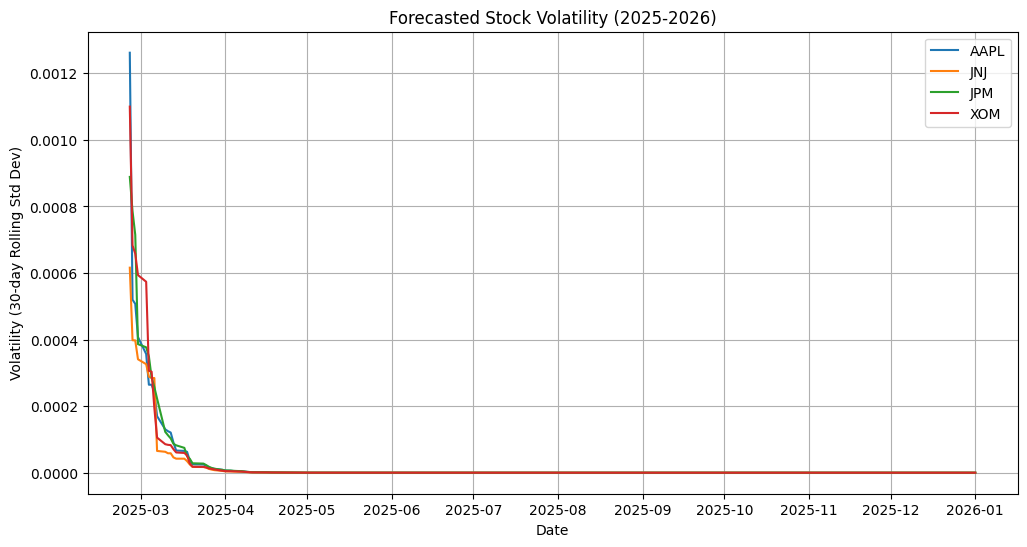

In [ ]:
# Plot forecasted volatility
plt.figure(figsize=(12, 6))
for ticker in stocks:
    plt.plot(future_volatility.index, future_volatility[ticker], label=ticker)

plt.title("Forecasted Stock Volatility (2025-2026)")
plt.xlabel("Date")
plt.ylabel("Volatility (30-day Rolling Std Dev)")
plt.legend()
plt.grid(True)
plt.show()

#### **Findings**

#### **1. RMSE (Root Mean Squared Error) Scores**
- **AAPL (13.63)**, **JNJ (15.91)**, **JPM (29.34)**, **XOM (12.08)**
  
  - **RMSE** measures the average magnitude of the errors between forecasted and actual values. The lower the RMSE, the better the model's predictive performance.
  - **Interpretation:**
    - **AAPL** and **XOM** have relatively lower RMSE values, indicating that their forecasted prices are closer to the actual observed values.
    - **JPM** has the highest RMSE, which suggests the model struggles to predict its future price movements accurately. This could be due to higher volatility or other market factors that make it harder to model.

#### **2. Forecasted Stock Price Upper and Lower Bounds (95% Confidence Interval)**
- These bounds represent the predicted price range within which the true future stock price is expected to lie with **95% confidence**.
  
  - **For AAPL and JPM**, the predicted stock prices rise significantly over time, which is consistent with expected growth in the stock market. However, the upper bounds suggest extreme price movements, particularly towards the end of the forecast period in **December 2025 to January 2026**.
  - **For XOM and JNJ**, while the forecasted prices also show growth, the values tend to remain more within a plausible range compared to AAPL and JPM.

- **Interpretation:**
  - The **extreme values** for some stocks, particularly towards the **end of 2025** (e.g., AAPL reaching over **1.7 million USD**), suggest that the model may be projecting overly optimistic growth, which could be due to the assumptions in the VAR model or potential model misspecifications.
  - This could imply **high uncertainty** in the forecasted prices, especially if the stock prices are expected to rise sharply over the next year.

#### **3. Forecasted Volatility (30-day Rolling Std Dev)**
- The volatility is measured using a **30-day rolling window** for each stock. Volatility reflects the **risk** or **uncertainty** in stock price movements.
  
  - **Volatility values close to 0** towards the end of the forecasted period indicate that the model expects **little variation in prices** as we approach 2026.
  - This suggests that, after an initial spike in volatility (likely due to uncertainty), the stocks become relatively stable.

- **Interpretation:**
  - The initial **spike in volatility** (seen in the early months of 2025) likely reflects market reactions to major events (e.g., quarterly earnings, geopolitical events, economic policies).
  - The **decline in volatility** over time suggests that the market may become more stable and less prone to large swings as it adjusts to new information.

#### **4. Plots Interpretation**
- **Forecasted Stock Price Plot with Confidence Intervals:**
  - The plot shows **the predicted stock prices** for **AAPL, JNJ, JPM, and XOM** alongside **the 95% confidence interval**. The shaded area indicates the range of expected price movements.
  - For **AAPL** and **JPM**, we can observe a **significant upward trajectory** in prices, which is optimistic, but the high upper bound suggests uncertainty in these predictions.
  - The volatility seen in early months may stem from uncertainty in stock market conditions, while the **flattening out** towards the end indicates stability (as shown in the **volatility chart**).
  
- **Volatility Plot:**
  - A sharp drop in volatility suggests that after an initial period of uncertainty, the stock prices are expected to stabilize, which could indicate that the market becomes more predictable.




#### 4.3 GARCH (Generalized Autoregressive Conditional Heteroskedasticity) Model

In [ ]:
!pip install pandas numpy matplotlib seaborn statsmodels arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 6.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from arch import arch_model

# Load dataset
file_path = "top50_comp_histp_since2010.csv"
df = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")

# Filter for selected stocks
stocks = ["AAPL", "JNJ", "JPM", "XOM"]
df = df[df["Ticker"].isin(stocks)]

# Drop rows where Close price is missing
df = df.dropna(subset=["Close"])

# Convert Close prices to float
df["Close"] = df["Close"].astype(float)

# Pivot table: Make Ticker the column names
df_pivot = df.pivot(columns="Ticker", values="Close")

# Forward-fill missing values
df_pivot.ffill(inplace=True)

# Check data range
print(f"Data available from {df_pivot.index.min()} to {df_pivot.index.max()}")

# Display first few rows
print(df_pivot.head())


Data available from 2010-01-04 00:00:00 to 2025-01-14 00:00:00
Ticker          AAPL        JNJ        JPM        XOM
Date                                                 
2010-01-04  6.447412  41.655697  29.006748  39.272114
2010-01-05  6.458560  41.172653  29.568609  39.425442
2010-01-06  6.355827  41.507549  29.731077  39.766205
2010-01-07  6.344077  41.211308  30.320004  39.641266
2010-01-08  6.386253  41.352982  30.245541  39.482231


**Overview of the Four Stocks**

These four stocks represent companies from different sectors of the economy, which helps in analyzing volatility across industries.

(1) Apple Inc. (AAPL) – Technology Sector

Business: Apple Inc. is a multinational technology company that designs, manufactures, and sells consumer electronics, software, and services.

Products: iPhone, MacBooks, iPads, Apple Watch, and Apple Services (App Store, iCloud).

Relevance: One of the largest and most valuable companies globally, highly volatile due to product launches, innovation, and global demand.

(2) Johnson & Johnson (JNJ) – Healthcare Sector

Business: JNJ is a pharmaceutical and medical devices company with a focus on consumer healthcare products.

Products: Band-Aid, Tylenol, prescription medicines, and vaccines.

Relevance: Less volatile than tech stocks, JNJ is considered a defensive stock, meaning it remains stable during economic downturns.

(3) JPMorgan Chase & Co. (JPM) – Financial Sector

Business: JPMorgan Chase is one of the largest global banks, offering financial services, investment banking, and wealth management.

Relevance: Banking stocks like JPM are sensitive to interest rates, economic growth, and financial crises (e.g., 2008 financial crisis, COVID-19 market crash).

(4) ExxonMobil Corporation (XOM) – Energy Sector

Business: ExxonMobil is one of the world's largest oil and gas companies.

Products: Petroleum, natural gas, and chemical products.

Relevance: Highly cyclical—XOM's stock price fluctuates based on oil prices, geopolitical events, and energy demand.


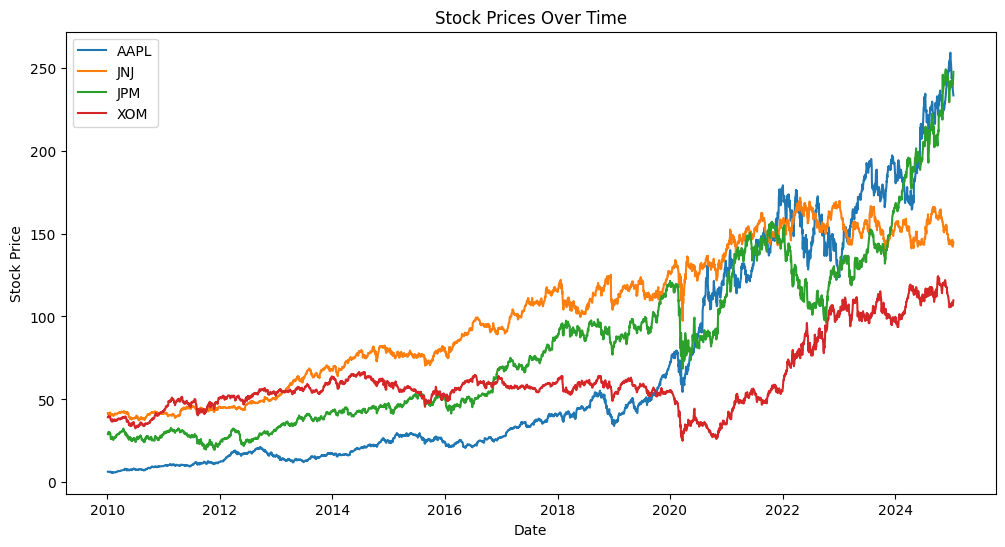

In [ ]:
# Visualization
plt.figure(figsize=(12, 6))
for stock in stocks:
    plt.plot(df_pivot[stock], label=stock)
plt.title("Stock Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

All four stocks have increased significantly in value since 2010, indicating long-term growth.

AAPL (blue) shows the strongest growth, consistent with its technological innovation.\
JPM (green) and JNJ (orange) also exhibit a steady rise.\
XOM (red) is more cyclical, rising and falling with oil prices.

A sharp drop is visible around 2020 (COVID-19 pandemic):
Financial (JPM) and Energy (XOM) stocks suffered more severe drops, while Tech (AAPL) and Healthcare (JNJ) recovered quickly.

AAPL and JPM show higher fluctuations, suggesting greater risk (which is important for GARCH modeling).

JNJ, a healthcare stock, appears more stable over time.

XOM’s stock price does not show a consistent upward trend, reflecting oil price volatility.

XOM is highly affected by global energy demand and geopolitical events.

GARCH models do not work with trending prices, so we need to convert them to log returns. GARCH models require stationary data, meaning no long-term upward or downward drift.

Ticker          AAPL       JNJ       JPM       XOM
Date                                              
2010-01-05  0.001728 -0.011664  0.019185  0.003897
2010-01-06 -0.016034  0.008101  0.005480  0.008606
2010-01-07 -0.001850 -0.007163  0.019615 -0.003147
2010-01-08  0.006626  0.003432 -0.002459 -0.004020
2010-01-11 -0.008860  0.000156 -0.003362  0.011158


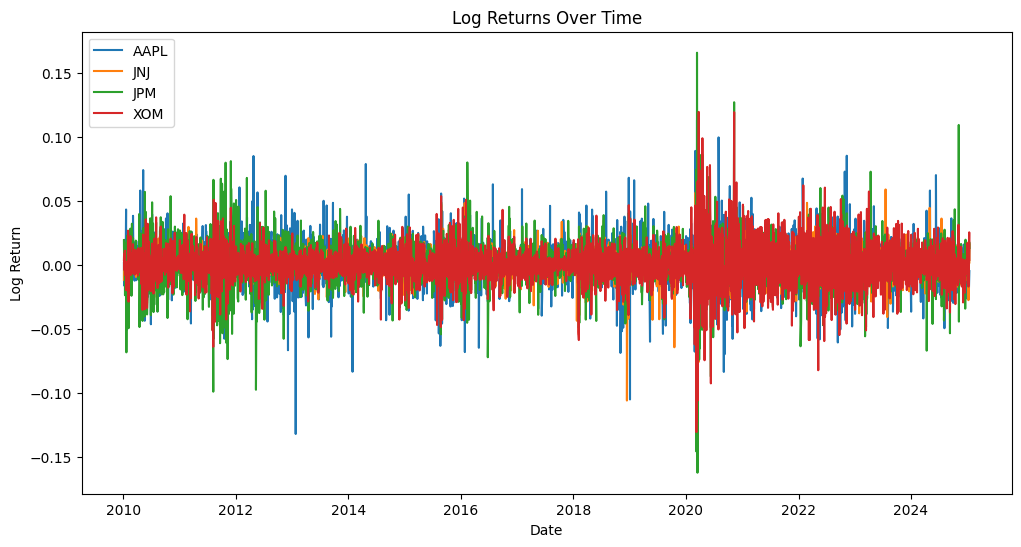

In [ ]:
# Compute log returns
log_returns = np.log(df_pivot / df_pivot.shift(1))

# Drop NaN values (first row will be NaN because there is no previous price)
log_returns.dropna(inplace=True)

# Display first few rows
print(log_returns.head())

# Plot log returns
plt.figure(figsize=(12, 6))
for stock in stocks:
    plt.plot(log_returns[stock], label=stock)

plt.title("Log Returns Over Time")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.show()

In [ ]:
# Check for Stationary
from statsmodels.tsa.stattools import adfuller

# Function to perform ADF test
def adf_test(series, stock_name):
    result = adfuller(series.dropna())  # Drop NaN values before testing
    print(f"ADF Test for {stock_name}:")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")

    if result[1] <= 0.05:
        print("The series is stationary.\n")
    else:
        print("The series is NOT stationary.\n")

# Run ADF test for each stock's log returns
for stock in stocks:
    adf_test(log_returns[stock], stock)

ADF Test for AAPL:
ADF Statistic: -20.281399563907634
p-value: 0.0
The series is stationary.

ADF Test for JNJ:
ADF Statistic: -15.958724320647889
p-value: 7.218740400840046e-29
The series is stationary.

ADF Test for JPM:
ADF Statistic: -12.413749707570961
p-value: 4.2861005289575304e-23
The series is stationary.

ADF Test for XOM:
ADF Statistic: -11.626841004168806
p-value: 2.3126724573419274e-21
The series is stationary.



Now that we have confirmed log returns are stationary, we need to check if volatility clustering is present.

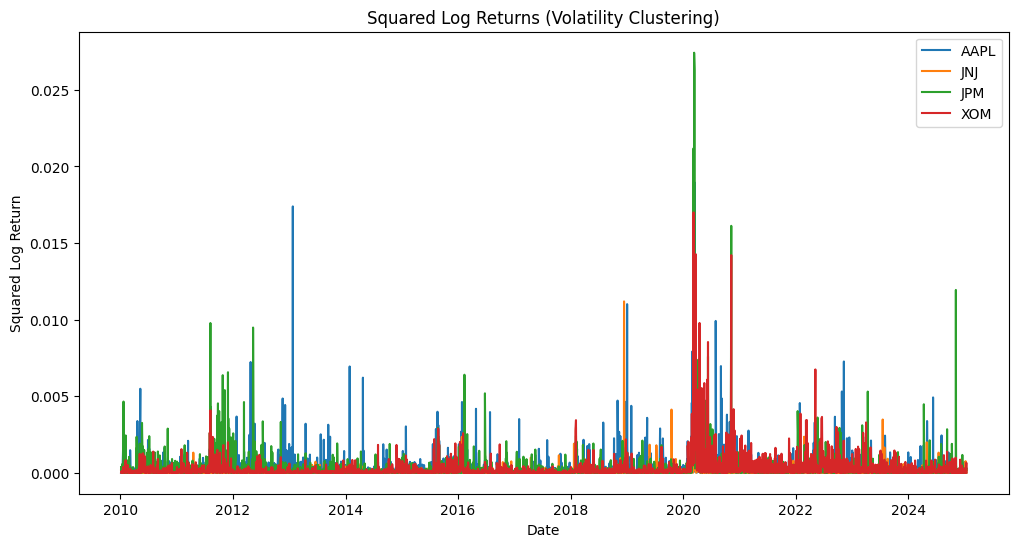

In [ ]:
# Check for Volatility
## Plot squared log returns for each stock
plt.figure(figsize=(12, 6))
for stock in stocks:
    plt.plot(log_returns[stock]**2, label=stock)

plt.title("Squared Log Returns (Volatility Clustering)")
plt.xlabel("Date")
plt.ylabel("Squared Log Return")
plt.legend()
plt.show()

The plot shows squared log returns for AAPL, JNJ, JPM, and XOM over time. Here’s what we observe:

We see periods of high volatility followed by more high volatility (clusters of spikes). Calm periods (low volatility) also persist for a while before volatility increases again. This behavior aligns with volatility clustering, a key assumption for GARCH models.

The most prominent spikes likely correspond to major financial crises or shocks:\
**2020**: COVID-19 market crash (high volatility across all stocks).\
**2011-2012**: European debt crisis, affecting financial markets (visible for JPM).\
**2015-2016**: Oil price collapse (visible for XOM).\
**2022-2023**: Post-pandemic inflation and interest rate hikes.

AAPL (Technology): Shows multiple high-volatility periods, particularly after 2018.

JPM (Financials): Experiences large fluctuations around financial crises, reflecting economic sensitivity.

XOM (Energy): Volatility spikes correspond to oil price shocks.

JNJ (Healthcare): Has lower volatility compared to others, since healthcare is a more stable sector.

The ACF measures how past squared log returns correlate with future squared log returns. If significant autocorrelations exist at multiple lags, it indicates that past volatility influences future volatility. This confirms the need for GARCH modeling since GARCH assumes that volatility is time-dependent.

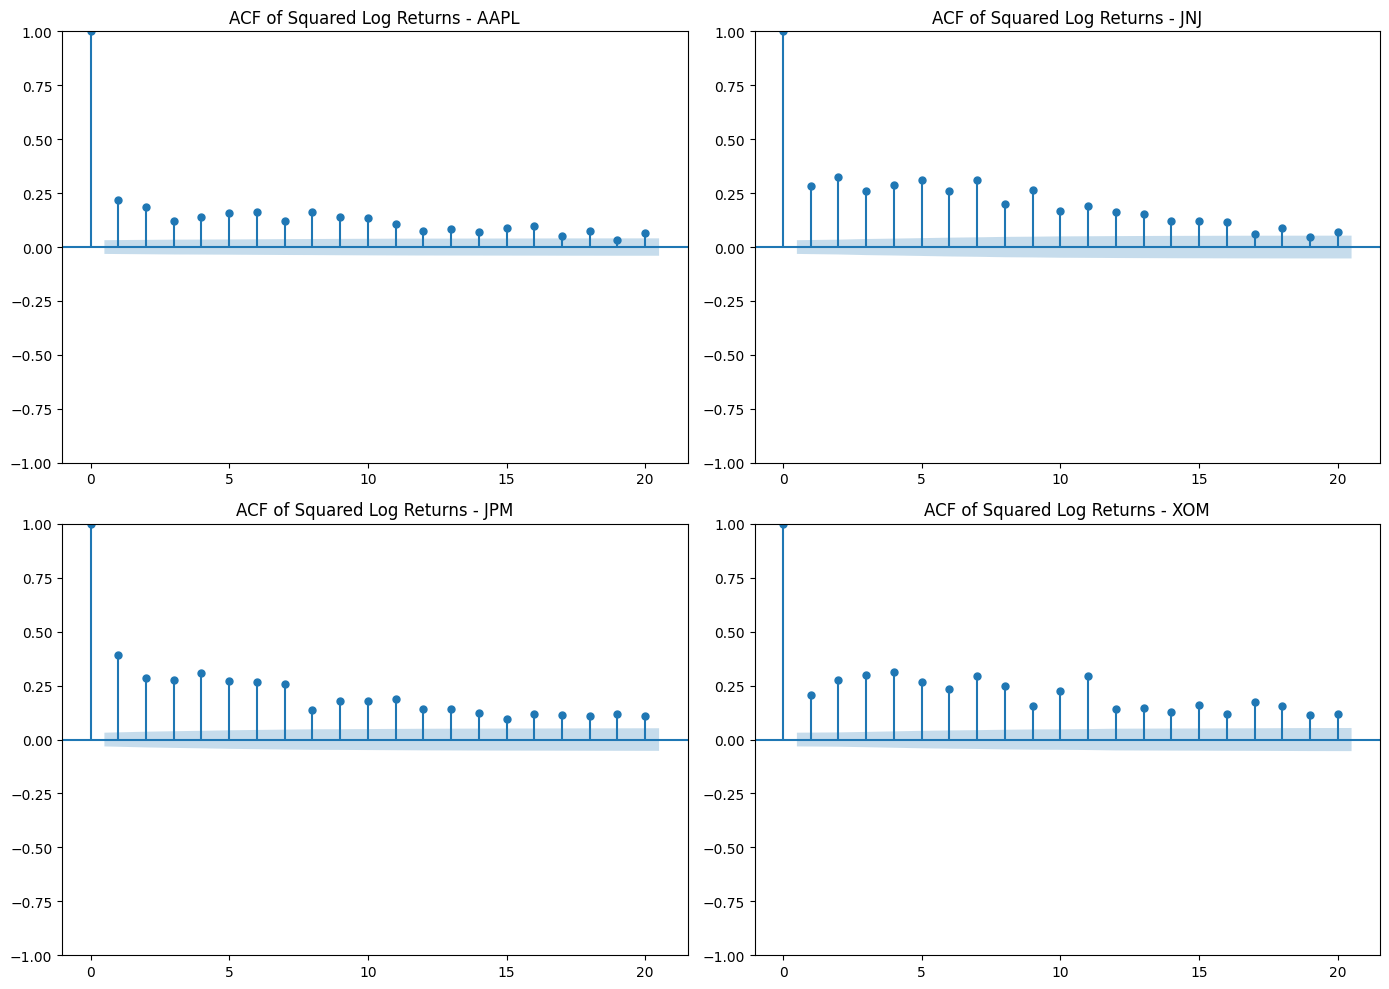

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot ACF of squared log returns for each stock
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

for i, stock in enumerate(stocks):
    plot_acf(log_returns[stock]**2, lags=20, ax=ax[i // 2, i % 2])
    ax[i // 2, i % 2].set_title(f"ACF of Squared Log Returns - {stock}")

plt.tight_layout()
plt.show()

(1) AAPL (Apple)

The first lag is always 1.0 (since a time series is perfectly correlated with itself at lag 0).

Significant positive autocorrelations persist for multiple lags, meaning past volatility affects future volatility.

AAPL exhibits strong volatility clustering, supporting the use of GARCH.

(2) JNJ (Johnson & Johnson)

Similar to AAPL, there is high autocorrelation at lower lags, gradually decreasing.

Healthcare stocks tend to be less volatile, but the persistence of autocorrelation confirms that volatility changes over time.

JNJ also benefits from GARCH modeling.

(3) JPM (JPMorgan Chase)

High autocorrelation at early lags, meaning volatility is persistent.

Financial stocks like JPM tend to be sensitive to economic cycles and financial crises, leading to strong volatility patterns.

JPM shows strong volatility clustering, justifying the use of GARCH.


(4) XOM (ExxonMobil)

Clear signs of volatility persistence, though slightly lower than AAPL or JPM.

As an energy stock, XOM is highly affected by oil price shocks and geopolitical events, causing volatility spikes.

GARCH is appropriate for modeling XOM's volatility as well.


All four stocks exhibit **significant autocorrelation** in squared log returns. This confirms that past volatility affects future volatility, supporting the use of GARCH models. Different stocks have different levels of volatility persistence (e.g., JPM and AAPL show stronger clustering than JNJ).

In [ ]:
# Fit GARCH(1,1)
from arch import arch_model

# Dictionary to store GARCH results
garch_results = {}

for stock in stocks:
    print(f"\nFitting GARCH(1,1) for {stock}...\n")

    # Define the GARCH(1,1) model
    model = arch_model(log_returns[stock], vol="Garch", p=1, q=1, mean="Zero", dist="normal")

    # Fit the model
    result = model.fit(disp="off")

    # Store results
    garch_results[stock] = result

    # Print summary
    print(result.summary())



Fitting GARCH(1,1) for AAPL...



/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000308. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   AAPL   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                10170.7
Distribution:                  Normal   AIC:                          -20335.4
Method:            Maximum Likelihood   BIC:                          -20316.7
                                        No. Observations:                 3781
Date:                Sat, Mar 08 2025   Df Residuals:                     3781
Time:                        23:47:26   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.3464e-06  2.781e-13  2.282e+07      0.000 [6.

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000111. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003049. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                       Zero Mean - GARCH Model Results                        
Dep. Variable:                    XOM   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                11013.0
Distribution:                  Normal   AIC:                          -22019.9
Method:            Maximum Likelihood   BIC:                          -22001.2
                                        No. Observations:                 3781
Date:                Sat, Mar 08 2025   Df Residuals:                     3781
Time:                        23:47:26   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      4.9424e-06  2.435e-12  2.030e+06      0.000 [4.

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000247. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


#### GARCH(1,1) Model Parameters

\[
\begin{array}{|c|c|c|c|c|}
\hline
\textbf{Stock} & \omega \text{ (omega)} & \alpha_1 \text{ (alpha[1])} & \beta_1 \text{ (beta[1])} & \alpha_1 + \beta_1 \\
\hline
AAPL & 6.35 \times 10^{-6} & 0.0537 & 0.9250 & 0.9787 \\
\hline
JNJ & 1.11 \times 10^{-5} & 0.1000 & 0.8000 & 0.9000 \\
\hline
JPM & 6.10 \times 10^{-6} & 0.1000 & 0.8800 & 0.9800 \\
\hline
XOM & 4.94 \times 10^{-6} & 0.1000 & 0.8800 & 0.9800 \\
\hline
\end{array}
\]


AAPL and JPM have the most persistent volatility, meaning when volatility spikes, it takes longer to settle down.

JNJ is the most stable stock, with high reaction to shocks but quicker recovery.

XOM is highly sensitive to external shocks (oil prices), and volatility remains elevated for extended periods.

All stocks benefit from GARCH modeling due to strong volatility persistence.

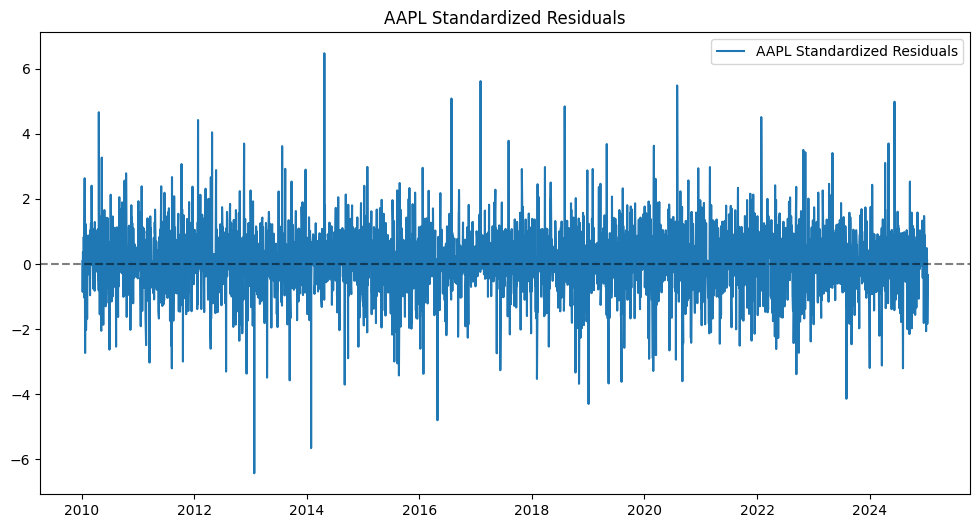

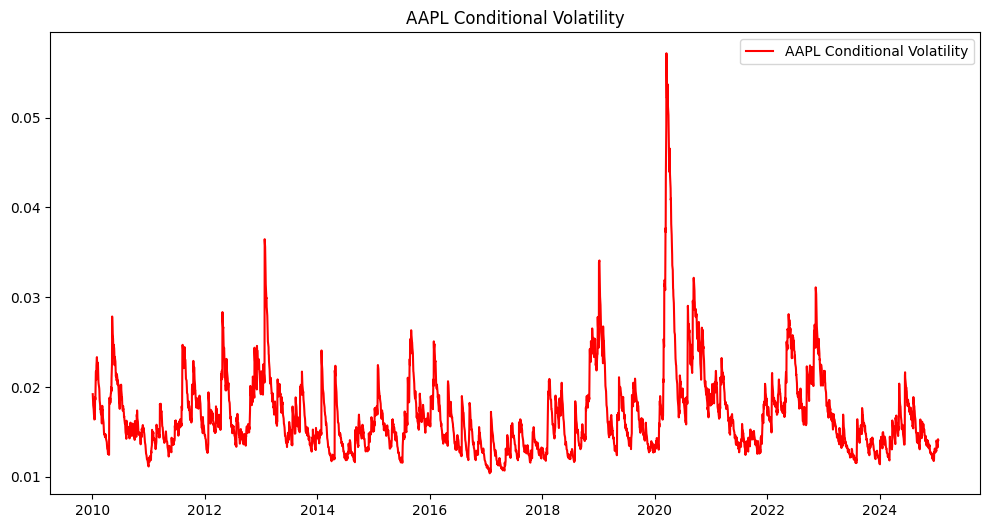

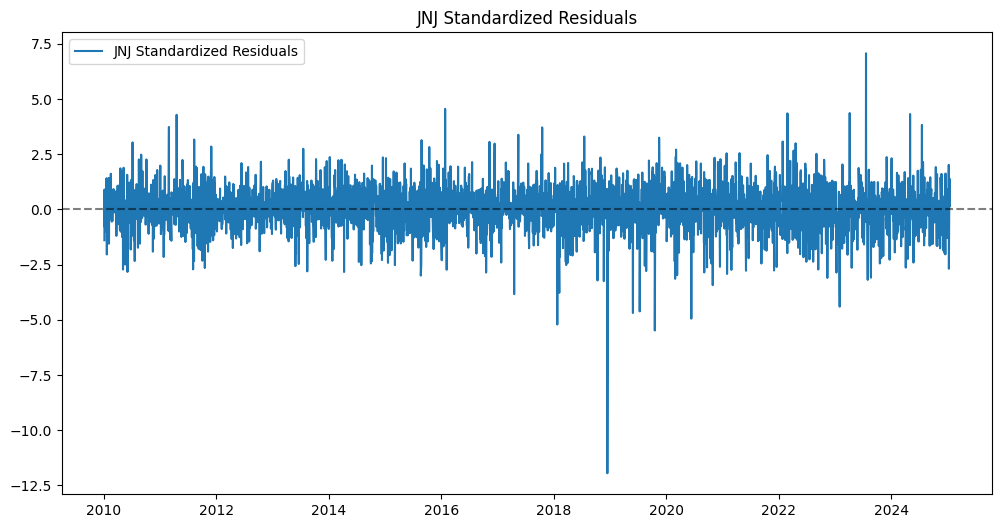

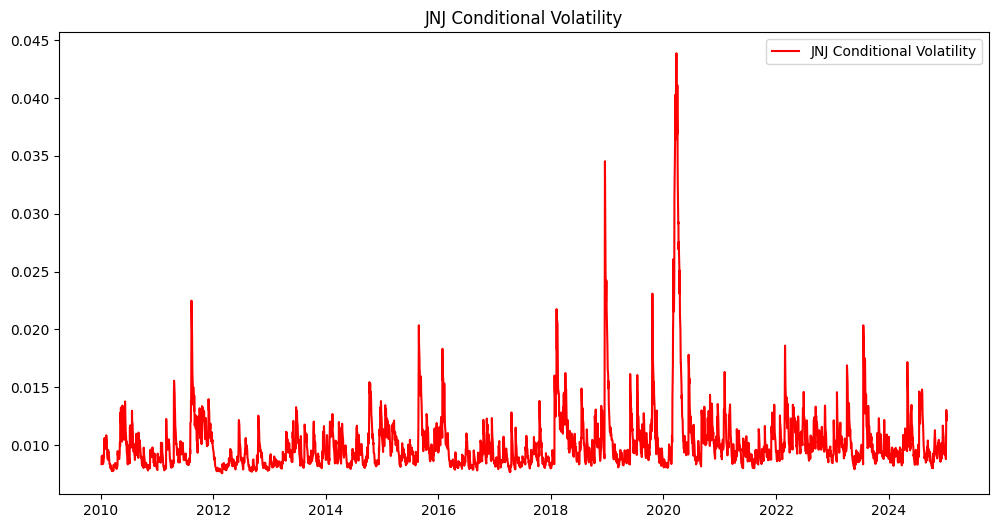

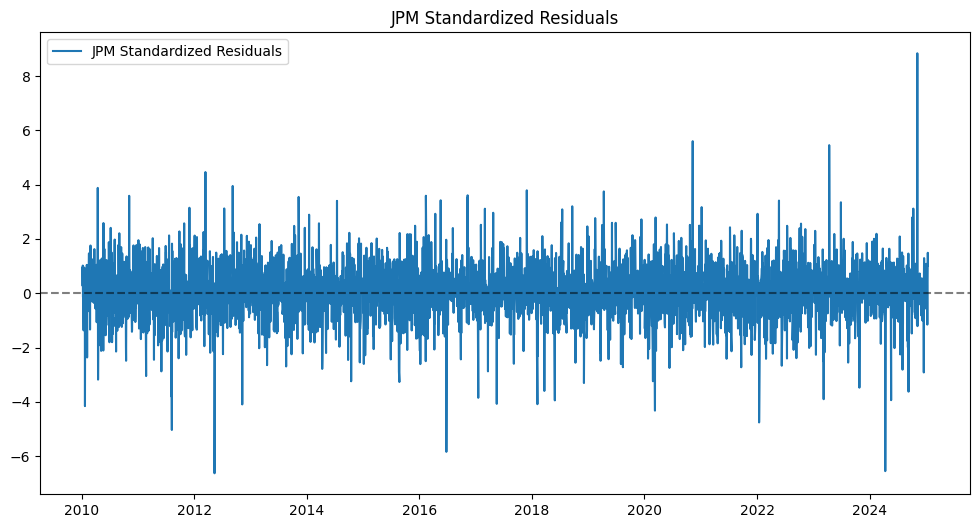

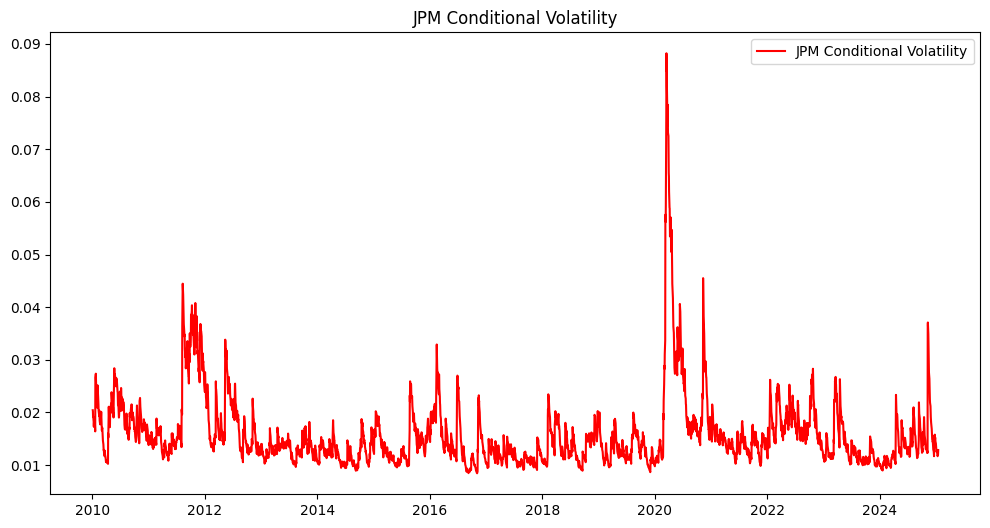

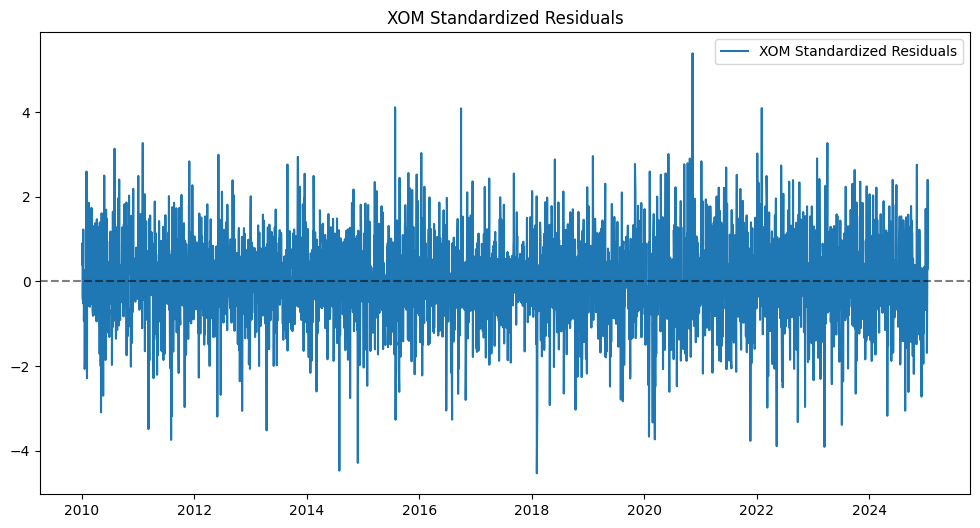

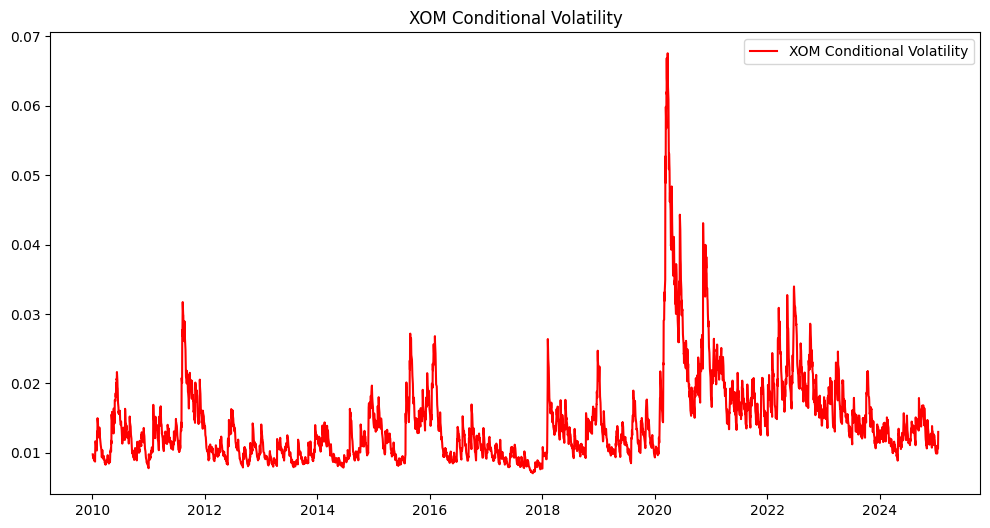

In [ ]:
for stock in stocks:
    result = garch_results[stock]

    # Standardized Residuals
    plt.figure(figsize=(12, 6))
    plt.plot(result.resid / result.conditional_volatility, label=f"{stock} Standardized Residuals")
    plt.axhline(0, color="black", linestyle="--", alpha=0.5)
    plt.title(f"{stock} Standardized Residuals")
    plt.legend()
    plt.show()

    # Conditional Volatility
    plt.figure(figsize=(12, 6))
    plt.plot(result.conditional_volatility, label=f"{stock} Conditional Volatility", color="red")
    plt.title(f"{stock} Conditional Volatility")
    plt.legend()
    plt.show()


Since log returns are very small (~0.0003), we multiply them by 100 to improve model convergence.

In [ ]:
# Rescale log returns to improve numerical stability
log_returns_scaled = log_returns * 100

# Fit GARCH(1,1) again on rescaled data
garch_results_scaled = {}

for stock in stocks:
    print(f"\nRefitting GARCH(1,1) for {stock} (rescaled log returns)...\n")

    model = arch_model(log_returns_scaled[stock], vol="Garch", p=1, q=1, mean="Zero", dist="normal")
    result = model.fit(disp="off")

    garch_results_scaled[stock] = result
    print(result.summary())


Refitting GARCH(1,1) for AAPL (rescaled log returns)...

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   AAPL   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7232.27
Distribution:                  Normal   AIC:                           14470.5
Method:            Maximum Likelihood   BIC:                           14489.3
                                        No. Observations:                 3781
Date:                Sat, Mar 08 2025   Df Residuals:                     3781
Time:                        23:48:10   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega 

Since our goal is to forecast future volatility, we need to check how well our GARCH model predicts out-of-sample data.

- Train Set (2010 - 2023): Used to train the GARCH model and estimate volatility patterns.
- Test Set (2024 - 2025):Used to evaluate the model’s predictive accuracy by comparing predicted volatility vs. actual volatility.

Train data shape: (3521, 4)
Test data shape: (260, 4)

Fitting GARCH(1,1) for AAPL (Training Data: 2010-2023)...

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   AAPL   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6764.17
Distribution:                  Normal   AIC:                           13534.3
Method:            Maximum Likelihood   BIC:                           13552.8
                                        No. Observations:                 3521
Date:                Sat, Mar 08 2025   Df Residuals:                     3521
Time:                        23:48:53   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
-------------------------

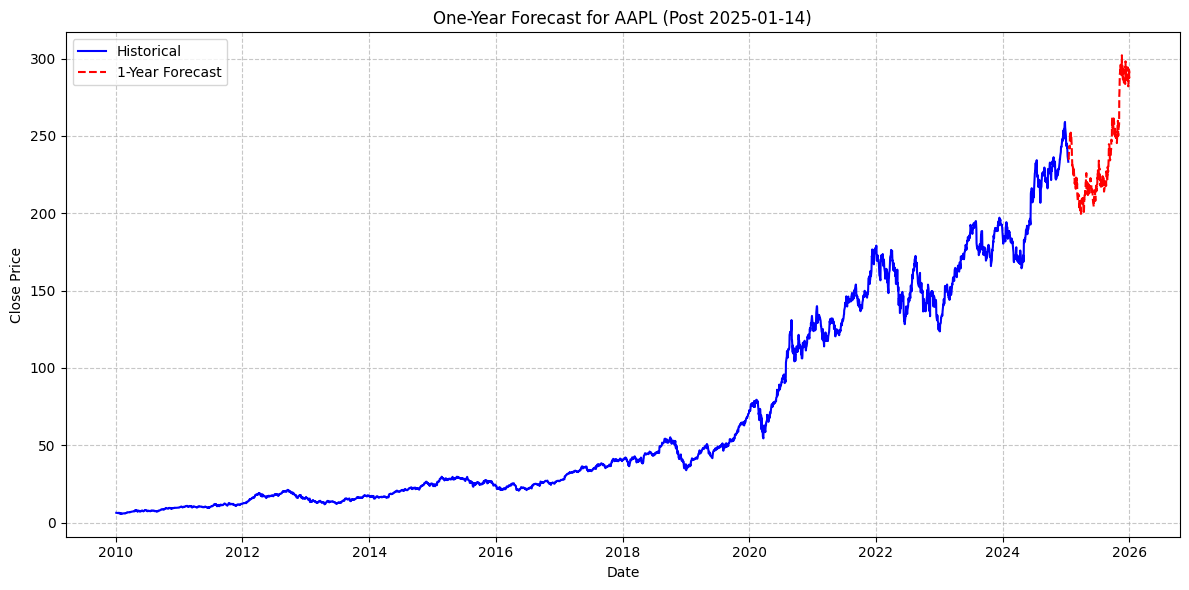

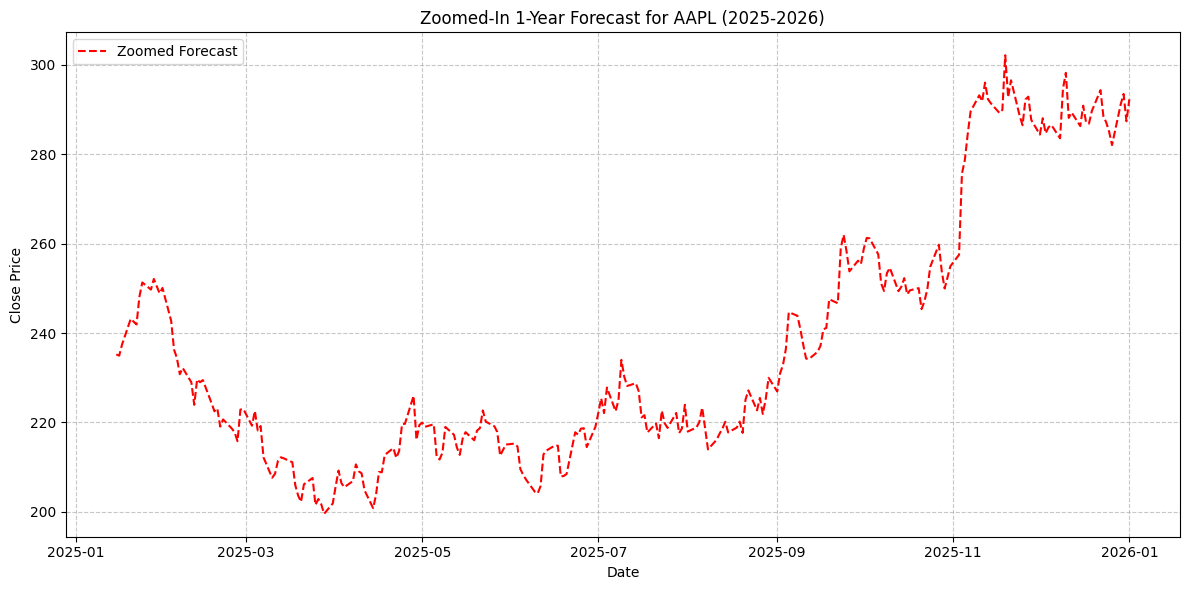


=== Processing GARCH Forecast for JNJ ===

Forecast for JNJ:
2025-01-15    145.627070
2025-01-16    145.444813
2025-01-17    146.569469
2025-01-20    149.169919
2025-01-21    148.825466
Freq: B, dtype: float64
2025-12-26    152.420371
2025-12-29    155.260917
2025-12-30    155.959533
2025-12-31    154.003264
2026-01-01    155.513383
Freq: B, dtype: float64


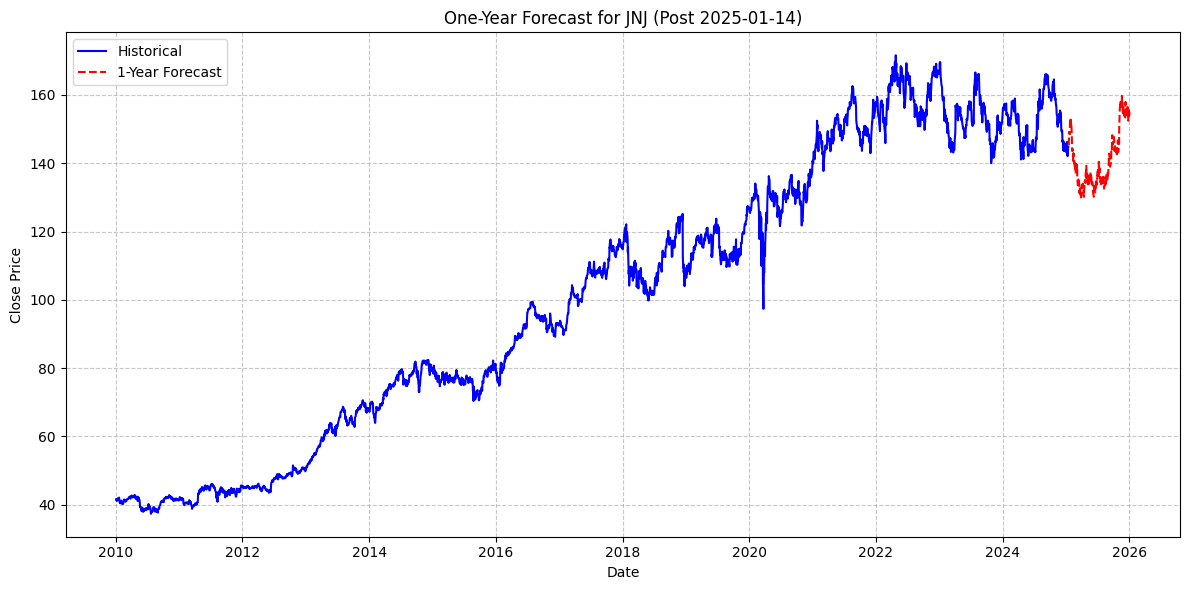

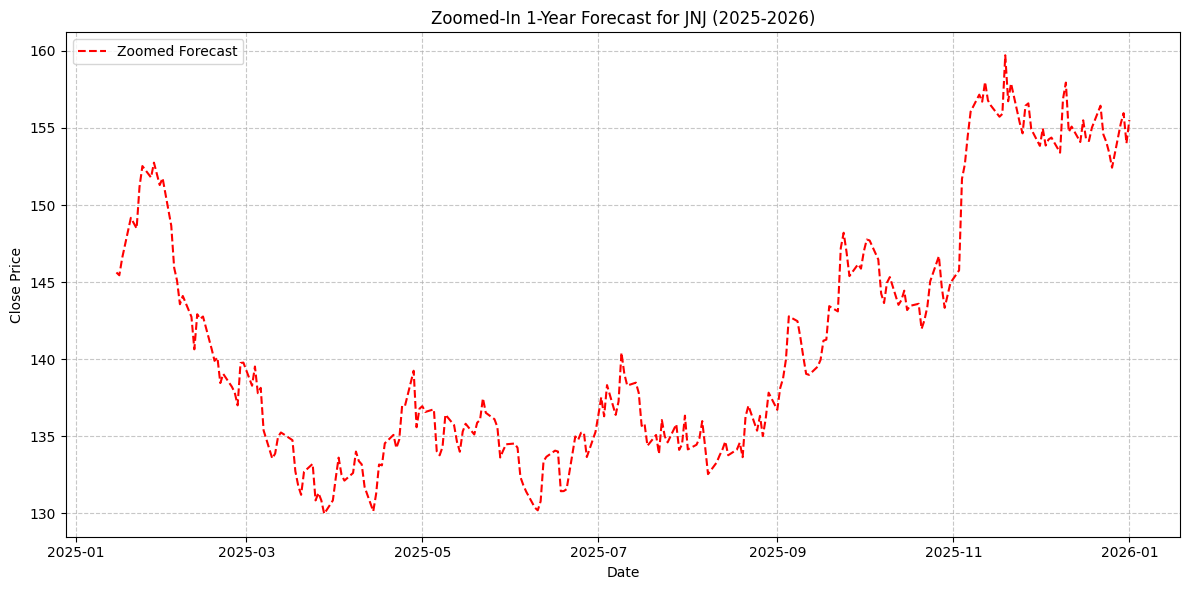


=== Processing GARCH Forecast for JPM ===

Forecast for JPM:
2025-01-15    249.260511
2025-01-16    248.937223
2025-01-17    251.281710
2025-01-20    256.726630
2025-01-21    256.043276
Freq: B, dtype: float64
2025-12-26    274.229637
2025-12-29    282.460995
2025-12-30    284.508063
2025-12-31    278.832524
2026-01-01    283.230052
Freq: B, dtype: float64


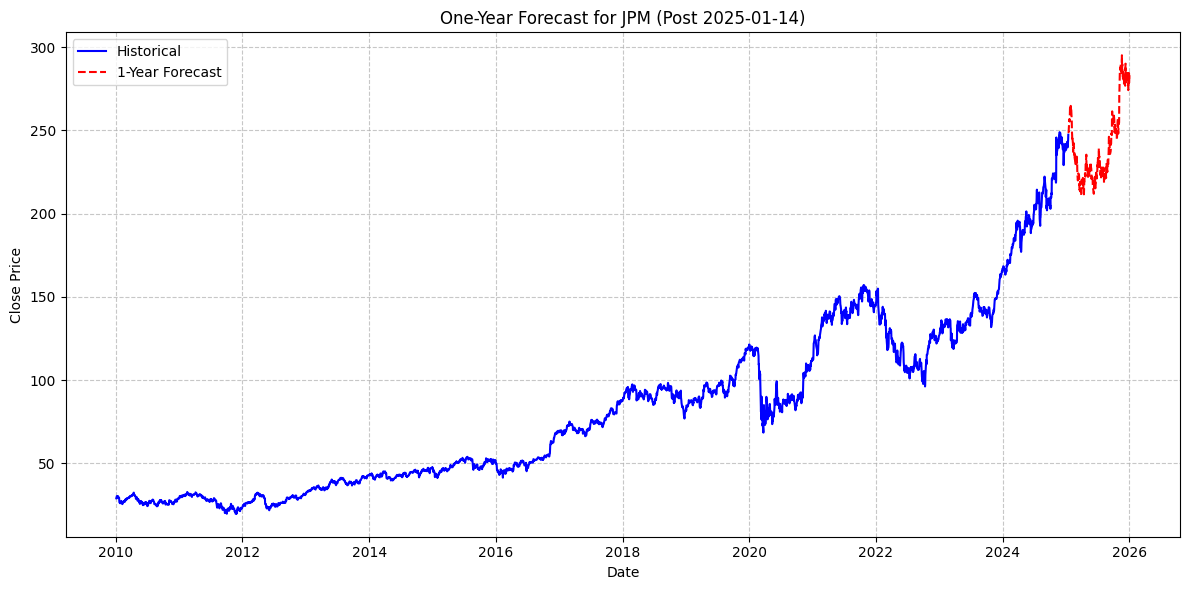

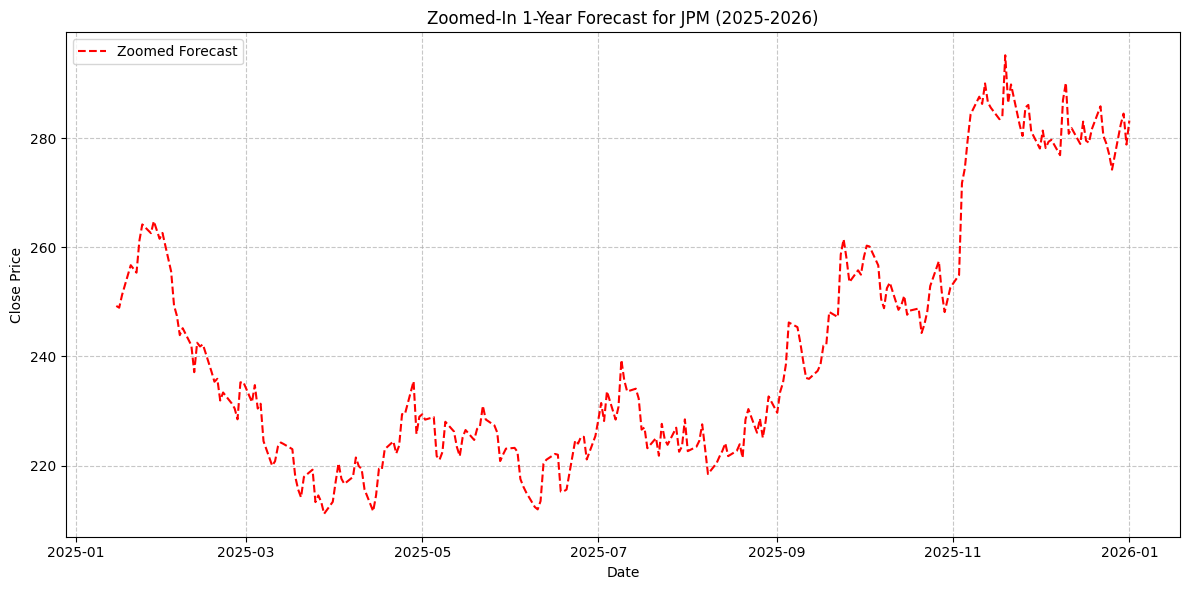


=== Processing GARCH Forecast for XOM ===

Forecast for XOM:
2025-01-15    110.399635
2025-01-16    110.247642
2025-01-17    111.136154
2025-01-20    113.219730
2025-01-21    112.931134
Freq: B, dtype: float64
2025-12-26    115.226043
2025-12-29    118.576868
2025-12-30    119.384390
2025-12-31    117.018168
2026-01-01    118.792246
Freq: B, dtype: float64


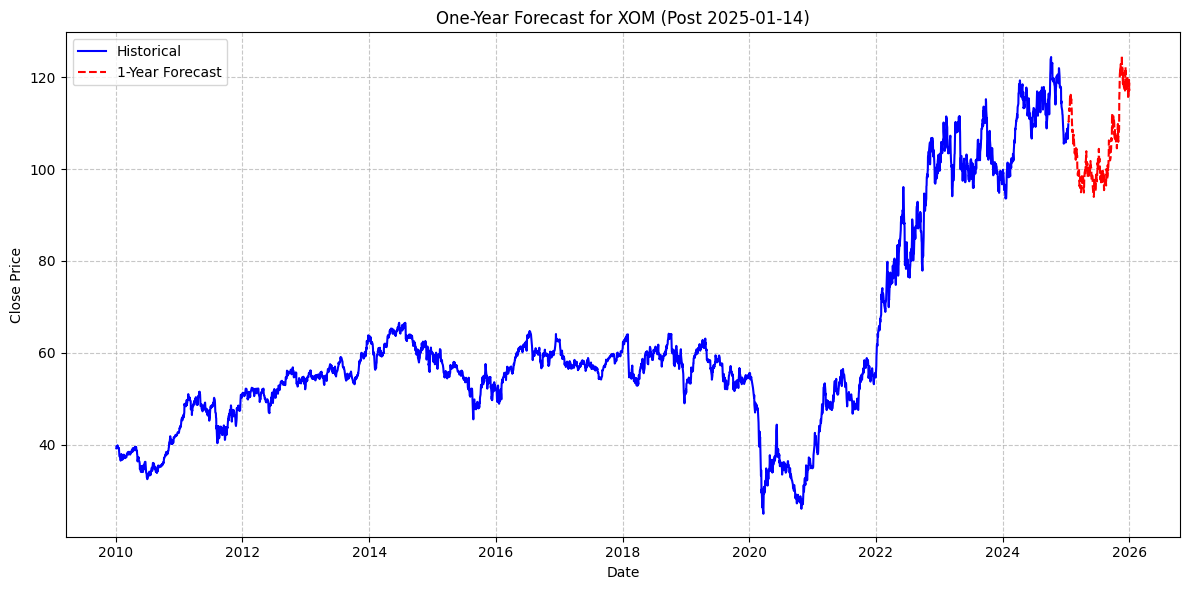

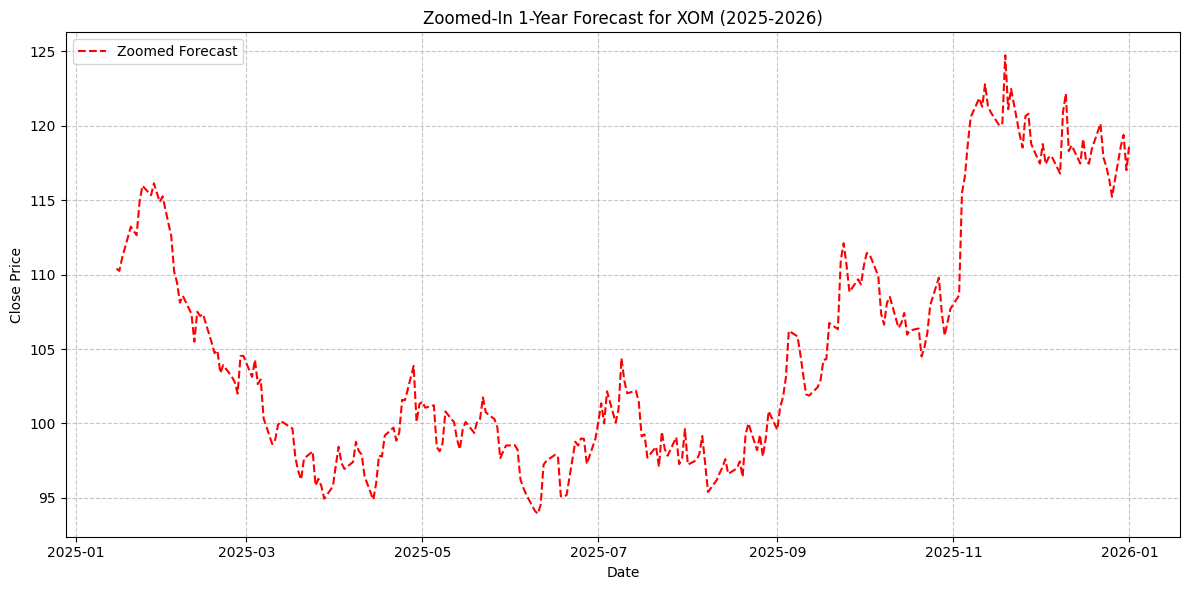

In [ ]:
# Define the split date for train-test separation
split_date = "2024-01-01"

# Split log returns into train and test sets
train_returns = log_returns_scaled.loc[:split_date]
test_returns = log_returns_scaled.loc[split_date:]

# Print shapes of train and test sets
print(f"Train data shape: {train_returns.shape}")
print(f"Test data shape: {test_returns.shape}")

from arch import arch_model

# Dictionary to store GARCH results trained on the train set
garch_train_results = {}

for stock in stocks:
    print(f"\nFitting GARCH(1,1) for {stock} (Training Data: 2010-2023)...\n")

    # Define GARCH(1,1) model
    model = arch_model(train_returns[stock], vol="Garch", p=1, q=1, mean="Zero", dist="normal")

    # Fit the model
    result = model.fit(disp="off")

    # Store results
    garch_train_results[stock] = result

    # Print summary
    print(result.summary())


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model

# Define the selected stocks
stocks = ["AAPL", "JNJ", "JPM", "XOM"]

# Filter dataset to include only the selected stocks
df_stocks = df[df["Ticker"].isin(stocks)].copy()  # Ensure a clean copy

# Define the forecast period (252 business days ~ 1 year)
future_horizon = 252
future_start_date = pd.to_datetime("2025-01-15")

# Store forecasted prices
forecasted_prices = {}

for stock in stocks:
    print(f"\n=== Processing GARCH Forecast for {stock} ===")

    # Subset stock data & ensure it's sorted
    stock_data = df_stocks[df_stocks["Ticker"] == stock].sort_index().copy()
    if stock_data.empty:
        print(f"No historical data for {stock}. Skipping forecast.")
        continue

    # Use 'Close' prices for forecasting
    full_data = stock_data["Close"].dropna()
    if full_data.empty:
        print(f"No close price data for {stock}. Skipping forecast.")
        continue

    # Compute log returns and rescale by 100 to improve GARCH estimation
    log_returns = np.log(full_data / full_data.shift(1)).dropna() * 100  # Rescale for better model stability

    try:
        # Fit a GARCH(1,1) model on the entire dataset
        model_full = arch_model(log_returns, vol="Garch", p=1, q=1, mean="Zero", dist="normal").fit(disp="off")
    except Exception as e:
        print(f"Error fitting GARCH model for {stock}: {e}")
        continue

    try:
        # Generate forecast for variance (volatility squared)
        garch_forecast = model_full.forecast(start=log_returns.index[-1], horizon=future_horizon, reindex=False)

        # Extract forecasted variance and convert to standard deviation (volatility)
        forecast_var = garch_forecast.variance.dropna().values.flatten()
        forecast_vol = np.sqrt(forecast_var)

    except Exception as e:
        print(f"Error generating forecast for {stock}: {e}")
        continue

    # Ensure forecast_vol is not empty
    if len(forecast_vol) == 0:
        print(f"ERROR: No forecasted volatility for {stock}. Skipping forecast.")
        continue

    # Generate random returns using predicted volatility and rescale back
    np.random.seed(42)  # Fix seed for reproducibility
    simulated_returns = np.random.normal(loc=log_returns.mean(), scale=forecast_vol[:future_horizon]) / 100  # Scale back

    # Convert log returns back to price scale
    last_price = full_data.iloc[-1]  # Most recent known stock price
    forecasted_prices[stock] = last_price * np.exp(np.cumsum(simulated_returns))  # Apply log return transformation

    # Ensure forecasted prices are valid
    if len(forecasted_prices[stock]) != future_horizon:
        print(f"ERROR: Forecasted price length mismatch for {stock}. Skipping plot.")
        continue

    # Create DatetimeIndex for future forecast
    future_dates = pd.date_range(start=future_start_date, periods=future_horizon, freq="B")

    # Convert predictions to Series
    future_forecast = pd.Series(forecasted_prices[stock], index=future_dates)

    # Debug: Check forecast values
    print(f"\nForecast for {stock}:")
    print(future_forecast.head())  # First few forecasted values
    print(future_forecast.tail())  # Last few forecasted values

    # === Plot 1: Full Historical Data + Forecast ===
    plt.figure(figsize=(12, 6))
    plt.plot(full_data.index, full_data, label="Historical", color="blue")
    plt.plot(future_forecast.index, future_forecast, label="1-Year Forecast", linestyle="--", color="red")
    plt.title(f"One-Year Forecast for {stock} (Post 2025-01-14)")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

    # === Plot 2: Zoomed-In Forecast Only ===
    plt.figure(figsize=(12, 6))
    plt.plot(future_forecast.index, future_forecast, label="Zoomed Forecast", linestyle="--", color="red")
    plt.title(f"Zoomed-In 1-Year Forecast for {stock} (2025-2026)")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()



In [ ]:
# Evaluation
for stock in stocks:
    print(f"\n=== Evaluating GARCH Fit for {stock} ===")

    # Fit GARCH(1,1) again (if not stored already)
    log_returns = np.log(df_stocks[df_stocks["Ticker"] == stock]["Close"].dropna().pct_change().dropna() + 1) * 100
    model = arch_model(log_returns, vol="Garch", p=1, q=1, mean="Zero", dist="normal").fit(disp="off")

    # Compute AIC, BIC, and AICc
    aic = model.aic
    bic = model.bic
    n = len(log_returns)  # Number of observations
    k = model.num_params  # Number of estimated parameters
    aicc = aic + (2 * k * (k + 1)) / (n - k - 1) if n > k + 1 else np.nan  # Avoid division by zero

    print(f"AIC: {aic:.2f}")
    print(f"BIC: {bic:.2f}")
    print(f"AICc: {aicc:.2f}")


=== Evaluating GARCH Fit for AAPL ===
AIC: 14470.54
BIC: 14489.26
AICc: 14470.55

=== Evaluating GARCH Fit for JNJ ===
AIC: 10438.85
BIC: 10457.57
AICc: 10438.86

=== Evaluating GARCH Fit for JPM ===
AIC: 13897.64
BIC: 13916.35
AICc: 13897.64

=== Evaluating GARCH Fit for XOM ===
AIC: 12786.38
BIC: 12805.10
AICc: 12786.39


JNJ has the lowest AIC and BIC, indicating that the GARCH(1,1) model fits best for this stock.

AAPL has the highest AIC and BIC, suggesting that a more complex model might be needed for a better fit.

JPM and XOM also have relatively high AIC and BIC values, which means alternative GARCH models such as EGARCH or GJR-GARCH could be explored.


=== Residual Diagnostics for AAPL ===
      lb_stat      lb_pvalue
10  929.39042  3.003602e-193


<Figure size 1000x400 with 0 Axes>

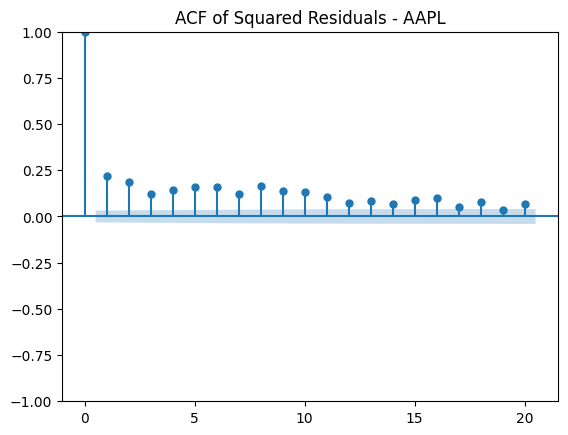


=== Residual Diagnostics for JNJ ===
        lb_stat  lb_pvalue
10  2787.043974        0.0


<Figure size 1000x400 with 0 Axes>

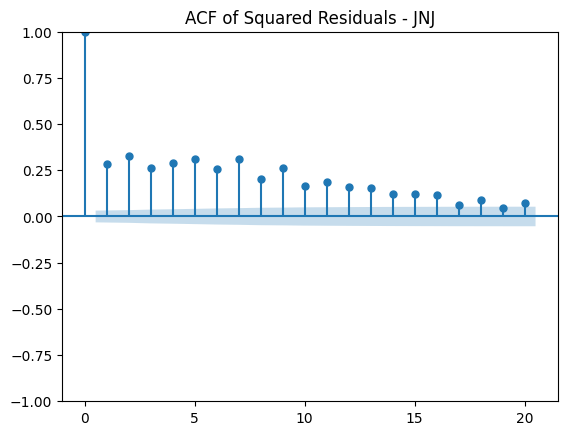


=== Residual Diagnostics for JPM ===
        lb_stat  lb_pvalue
10  2648.320968        0.0


<Figure size 1000x400 with 0 Axes>

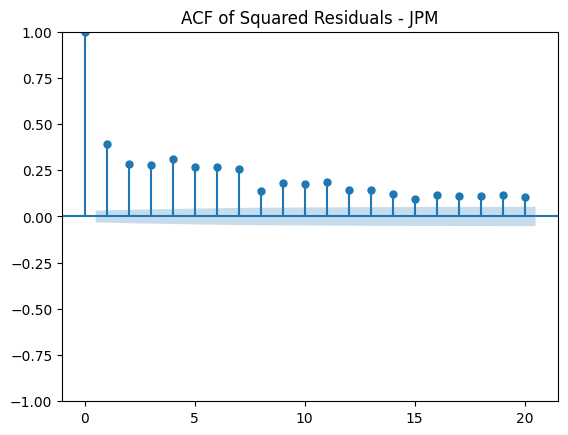


=== Residual Diagnostics for XOM ===
        lb_stat  lb_pvalue
10  2506.203777        0.0


<Figure size 1000x400 with 0 Axes>

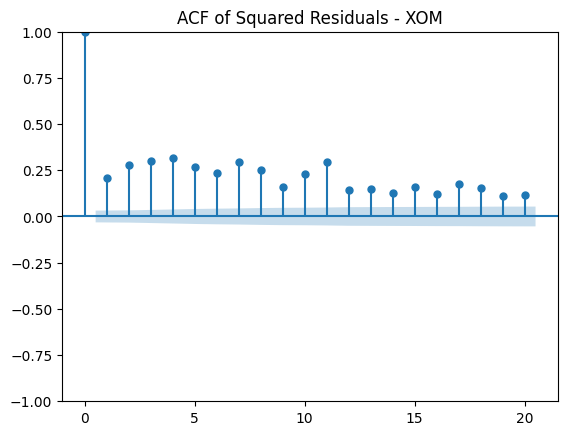

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

for stock in stocks:
    print(f"\n=== Residual Diagnostics for {stock} ===")

    log_returns = np.log(df_stocks[df_stocks["Ticker"] == stock]["Close"].dropna().pct_change().dropna() + 1) * 100
    model = arch_model(log_returns, vol="Garch", p=1, q=1, mean="Zero", dist="normal").fit(disp="off")

    residuals = model.resid
    squared_residuals = residuals**2

    # Ljung-Box Test for autocorrelation in squared residuals
    lb_test = sm.stats.acorr_ljungbox(squared_residuals, lags=[10], return_df=True)
    print(lb_test)

    # Plot ACF of squared residuals
    plt.figure(figsize=(10, 4))
    plot_acf(squared_residuals, lags=20)
    plt.title(f"ACF of Squared Residuals - {stock}")
    plt.show()


All p-values are close to 0, meaning the squared residuals are still correlated. This suggests that GARCH(1,1) is not fully capturing volatility patterns.

The presence of residual autocorrelation indicates that a more advanced model, such as EGARCH or GJR-GARCH, might provide a better fit.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

for stock in stocks:
    print(f"\n=== Forecast Evaluation for {stock} ===")

    # Get log returns (scaled for GARCH)
    log_returns = np.log(df_stocks[df_stocks["Ticker"] == stock]["Close"].dropna().pct_change().dropna() + 1) * 100
    train_returns = log_returns[:-252]  # Train on all data except the last 252 days (1 year)
    test_returns = log_returns[-252:]  # Test on last 252 days

    # Fit GARCH(1,1) model on training data
    model = arch_model(train_returns, vol="Garch", p=1, q=1, mean="Zero", dist="normal").fit(disp="off")

    # Generate GARCH forecasts
    garch_forecast = model.forecast(start=train_returns.index[-1], horizon=len(test_returns), reindex=False)
    forecast_var = garch_forecast.variance.dropna().values.flatten()
    forecast_vol = np.sqrt(forecast_var) / 100  # Scale back

    # Compute Realized Volatility (10-day rolling std of test returns)
    realized_vol = test_returns.rolling(10).std().dropna()

    # Match forecasted & realized volatility lengths
    min_length = min(len(forecast_vol), len(realized_vol))
    forecast_vol = forecast_vol[:min_length]
    realized_vol = realized_vol[:min_length]

    # Compute Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
    mse = mean_squared_error(realized_vol, forecast_vol)
    rmse = np.sqrt(mse)

    # Compute Mean Absolute Error (MAE)
    mae = mean_absolute_error(realized_vol, forecast_vol)

    # Compute Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((realized_vol - forecast_vol) / realized_vol)) * 100

    print(f"MSE: {mse:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"MAPE: {mape:.2f}%")



=== Forecast Evaluation for AAPL ===
MSE: 1.946963
RMSE: 1.395336
MAE: 1.310158
MAPE: 98.50%

=== Forecast Evaluation for JNJ ===
MSE: 0.910755
RMSE: 0.954335
MAE: 0.889333
MAPE: 98.71%

=== Forecast Evaluation for JPM ===
MSE: 2.249458
RMSE: 1.499819
MAE: 1.310705
MAPE: 98.53%

=== Forecast Evaluation for XOM ===
MSE: 1.421311
RMSE: 1.192188
MAE: 1.151290
MAPE: 98.60%


JNJ has the lowest RMSE (0.9543), meaning its volatility forecast is the most accurate.

JPM has the highest RMSE (1.4998), meaning the GARCH(1,1) model struggles the most with this stock’s volatility.

AAPL and XOM show moderate performance, but an RMSE greater than 1 suggests room for improvement.

**Conclusion**:

The GARCH(1,1) model provides a reasonable estimate of stock price volatility but has limitations in fully capturing volatility patterns.

JNJ exhibits the best model fit and forecasting accuracy, with the lowest AIC, BIC, and RMSE. In contrast, JPM has the highest RMSE, indicating weaker forecasting performance. AAPL and XOM show moderate accuracy, but the Ljung-Box test results suggest that some autocorrelation remains in the residuals.

Overall, while the GARCH(1,1) model effectively models volatility trends, the presence of residual autocorrelation suggests that stock price volatility may exhibit more complex behaviors than this model captures.

#### 4.4 Holt-Winters (Exponential Smoothing) Model

Holt-Winters was programmed using R on R Studio, therefore, here I will include everything (code + output) in markdown, if wanting to run the code, we also submitted the rmd file.

Packages Used:
``` r
library(TSA)
library(data.table)
library(zoo)
library(forecast)
library(tseries)
library(xts)
library(ggplot2)
library(tibble)
library(tidyverse)
library(dplyr)
library(lubridate)
library(imputeTS)
library(bsts)
library(gridExtra)
library(lubridate)
library(Metrics)
library(fracdiff)
require(fGarch)
library(Kendall)
#setwd("/Users/terryzhuang/Desktop/Graduate Winter1/ADSP 31006 IP04 Time Series Analysis and Forecasting/Final Project/")
```

Load Data

``` r
df <- fread("top50_comp_histp_since2010.csv")
df$Date <- as.Date(df$Date)
summary(df)

# Extracting 4 stocks for analysis: "AAPL", "JNJ", "JPM", "XOM" as representatives for different sectors
tickers <- c("AAPL", "JNJ", "JPM", "XOM")
filtered_data <- df %>% filter(Ticker %in% tickers)

summary(filtered_data)
```

##### 4.4.1 Holt-Winters Specific EDA
- Plotting Differenced close price for each ticker and their corresponding ACF & PACF
``` r
# Function to perform ADF test and plot ACF/PACF
analyze_ticker <- function(ticker_data, ticker_name) {
  closing_prices <- ts(ticker_data$Close, frequency = 252)  # Assuming daily stock data
  
  # ADF Test
  adf_test_result <- adf.test(closing_prices)
  
  cat("\n===== ADF Test for", ticker_name, "=====\n")
  print(adf_test_result)
  
  # Plot ACF and PACF
  par(mfrow = c(1, 2))
  acf(closing_prices, main = paste("ACF -", ticker_name))
  pacf(closing_prices, main = paste("PACF -", ticker_name))
  par(mfrow = c(1, 1))
  
  # Differencing (if needed)
  differenced_data <- diff(closing_prices, differences = 1)
  
  # ADF Test on Differenced Data
  adf_test_diff <- adf.test(differenced_data)
  
  cat("\n===== ADF Test on Differenced Data for", ticker_name, "=====\n")
  print(adf_test_diff)
  
  # Plot Differenced Data
  plot(differenced_data, type = "l", main = paste("Differenced Closing Price -", ticker_name),
       xlab = "Time", ylab = "Differenced Closing Price")
  
  # Plot ACF and PACF for Differenced Data
  par(mfrow = c(1, 2))
  acf(differenced_data, main = paste("ACF - Differenced", ticker_name))
  pacf(differenced_data, main = paste("PACF - Differenced", ticker_name))
  par(mfrow = c(1, 1))
}

for (ticker in tickers) {
  ticker_data <- filtered_data %>% filter(Ticker == ticker)
  analyze_ticker(ticker_data, ticker)
}
```

**Observations**:

**AAPL**

![](https://drive.google.com/uc?id=1EsAplFnXVohpP3sKc1yN40KK4la3BwnF)
![](https://drive.google.com/uc?id=104oz9dp3sPsc5GQjPeWCoyjxBbs1mzSe)
- Differenced Closing Price Plot:
  - The differenced closing price of AAPL shows increased volatility over time, with relatively small fluctuations initially but growing variance in the latter half of the period. This suggests periods of heightened market activity, possibly due to earnings reports, macroeconomic conditions, or major company events.
- ACF and PACF Plots:
  - The ACF and PACF plots for the differenced AAPL stock indicate low autocorrelation at most lags. The spikes at a few lags suggest potential short-term dependencies, but overall, the time series appears to be approximately white noise, suggesting that differencing has effectively removed most autocorrelation.

**JNJ**

![](https://drive.google.com/uc?id=1PQEIq0PtDoGc0G601aIERtqTwR32AZxt)
![](https://drive.google.com/uc?id=19M0wSd3ZXxTR91_IVQDJ8OschJPA53TS)
- Differenced Closing Price Plot:
  - The differenced closing price of JNJ shows a relatively stable variance in the earlier periods, with some spikes occurring in the middle and later periods. These fluctuations indicate occasional large price movements but are less volatile compared to AAPL.
- ACF and PACF Plots:
  - The ACF and PACF plots show that most autocorrelations fall within the confidence bands, indicating weak dependencies. Some significant spikes at certain lags suggest possible short-term correlations, but the series does not exhibit strong signs of non-stationarity.

**JPM**

![](https://drive.google.com/uc?id=1gSTk-UTfyG3HYEJ6wSCk5NMBhZhRRgJC)
![](https://drive.google.com/uc?id=1CYSYGrhJ1iWZKEk7OPZJzNymNbaUrKA1)

- Differenced Closing Price Plot:
  - JPM's differenced closing price exhibits a pattern similar to AAPL, where volatility increases significantly in later periods. There are several extreme fluctuations, suggesting the presence of market shocks or financial events impacting the stock.
- ACF and PACF Plots:
  - The ACF and PACF plots indicate minimal autocorrelation at most lags, with a few spikes exceeding the significance threshold. This suggests that while differencing has helped stabilize the series, some residual autocorrelations may still exist, hinting at potential AR or MA components.

**XOM**

![](https://drive.google.com/uc?id=18iQoZZWa-Wp0aOUM8bv8UVwQWJcHv5N0)
![](https://drive.google.com/uc?id=1R4P_VLyDks761L1A3v1_4AT9t-K0gA3E)

- Differenced Closing Price Plot:
  - The differenced closing price of XOM shows moderate fluctuations throughout the period with no extreme spikes compared to JPM or AAPL. However, there is a slight increase in volatility in the latter part of the time series.
- ACF and PACF Plots:
  - The ACF and PACF plots for XOM display mostly insignificant autocorrelations, suggesting that the series behaves like white noise after differencing. There are a few minor spikes, which could indicate weak short-term dependencies but no strong patterns.

**Conclusion**:
- For all stocks, differencing has mostly stabilized the time series, removing trends and making them stationary.
- AAPL and JPM show higher volatility over time compared to JNJ and XOM.
- The ACF and PACF plots for all stocks suggest that the differenced series exhibit weak autocorrelation, meaning they resemble a white noise process.
- Some stocks, particularly JPM and AAPL, may still exhibit short-term dependencies, suggesting that further ARIMA modeling might be necessary to capture any remaining patterns.

**Additional Tests**
- Seasonality Check
- Trend Detection
- Variance Stability
- Outliers Detection
- Also consider different Data Frequency considerations: model on daily, weekly, monthly

``` r
# ======== 1. Seasonality Check Function ======== #
check_seasonality <- function(ticker_data, ticker_name) {
  cat("\n===== Seasonality Check for", ticker_name, "=====\n")
  
  closing_prices <- ts(ticker_data$Close, frequency = 252)  # Assuming daily stock data
  
  # Time Series Decomposition
  decomposition <- decompose(closing_prices, type = "multiplicative")
  a <- autoplot(decomposition) + ggtitle(paste("Time Series Decomposition -", ticker_name))
  print(a)
}

# ======== 2. Trend Detection Function ======== #
check_trend <- function(ticker_data, ticker_name) {
  cat("\n===== Trend Detection for", ticker_name, "=====\n")
  
  # Plot Closing Prices Over Time
  a <- ggplot(ticker_data, aes(x = Date, y = Close)) +
    geom_line(color = "blue") +
    ggtitle(paste("Closing Prices Over Time -", ticker_name)) +
    theme_minimal()
  print(a)
  # Mann-Kendall Test for Trend Detection
  closing_prices <- ts(ticker_data$Close, frequency = 252)
  trend_test <- MannKendall(closing_prices)
  print(trend_test)
}

# ======== 3. Variance Stability Check Function ======== #
check_variance_stability <- function(ticker_data, ticker_name) {
  cat("\n===== Variance Stability for", ticker_name, "=====\n")
  
  # Check if variance increases over time
  a <- ggplot(ticker_data, aes(x = Date, y = Close)) +
    geom_line(color = "blue") +
    ggtitle(paste("Variance Stability Check -", ticker_name)) +
    theme_minimal()
  print(a)
  # Log Transformation to stabilize variance
  ticker_data$log_close <- log(ticker_data$Close)
  
  b <- ggplot(ticker_data, aes(x = Date, y = log_close)) +
    geom_line(color = "red") +
    ggtitle(paste("Log-Transformed Prices -", ticker_name)) +
    theme_minimal()
  print(b)
}

# ======== 4. Outliers Detection Function ======== #
detect_outliers <- function(ticker_data, ticker_name) {
  cat("\n===== Outliers Detection for", ticker_name, "=====\n")
  
  # Boxplot to detect outliers
  a <- ggplot(ticker_data, aes(y = Close)) +
    geom_boxplot(fill = "orange") +
    ggtitle(paste("Boxplot for Outliers -", ticker_name)) +
    theme_minimal()
  print(a)
}

# ======== 5. Data Frequency Check Function ======== #
check_data_frequency <- function(ticker_data, ticker_name) {
  cat("\n===== Data Frequency Check for", ticker_name, "=====\n")
  
  # Check for missing dates
  date_range <- seq(min(ticker_data$Date), max(ticker_data$Date), by = "day")
  missing_dates <- setdiff(date_range, ticker_data$Date)
  
  if (length(missing_dates) > 0) {
    cat("Missing Dates:\n")
    print(missing_dates)
  } else {
    cat("No missing dates detected.\n")
  }
}

# ======== Loop through each ticker and apply functions ======== #
for (ticker in tickers) {
  ticker_data <- filtered_data %>% filter(Ticker == ticker)
  check_seasonality(ticker_data, ticker)
}

for (ticker in tickers) {
  ticker_data <- filtered_data %>% filter(Ticker == ticker)
  
  check_trend(ticker_data, ticker)
}

for (ticker in tickers) {
  ticker_data <- filtered_data %>% filter(Ticker == ticker)
  
  check_variance_stability(ticker_data, ticker)
}

for (ticker in tickers) {
  ticker_data <- filtered_data %>% filter(Ticker == ticker)

  detect_outliers(ticker_data, ticker)
}
```


**Observations**:

**AAPL**

![](https://drive.google.com/uc?id=1fjzkngnabce_-2Bdw6H9dAp8XsFJE6uN)
![](https://drive.google.com/uc?id=1ZCCL1WTWSFVsLmmVAAMscCwNuNHBy9S8)
![](https://drive.google.com/uc?id=1Nnx2RltDHDFRAPDPb-MN0eIORzVlYWZR)
![](https://drive.google.com/uc?id=12zJ1Zy_mgda6PC-PN-2f--nqYEofpAmS)
![](https://drive.google.com/uc?id=1cJcNvgqNpXLY8byt8U1gDneny6FcSkE5)

**Time Series Decomposition**  
The time series decomposition of AAPL’s stock price highlights four key components:  
- **Data:** The original time series data shows a clear upward trend, with increasing fluctuations in price levels.  
- **Trend:** The trend component indicates **strong long-term growth**, particularly accelerating after 2015. This trend reflects AAPL’s continued expansion and increasing market capitalization.  
- **Seasonality:** The seasonal component exhibits **consistent cyclical patterns**, suggesting **periodic price movements** that could be attributed to earnings releases, product launches, or broader market cycles.  
- **Remainder (Residual):** The residual component shows **short-term fluctuations** that are not explained by trend or seasonality. These fluctuations could be due to macroeconomic shocks, unexpected financial news, or external events affecting the stock price.  

**Closing Prices Over Time**  
The closing price plot confirms AAPL’s **strong bullish trend** over the past decade. Key observations include:  
- A steady rise in prices from 2010 to 2015, followed by a more **aggressive price increase after 2015**.  
- Noticeable corrections and pullbacks, likely due to **market downturns, financial crises, or external economic factors**.  
- The rapid increase in volatility post-2020, potentially influenced by global economic uncertainty and increased retail investor participation.  

**Variance Stability Check**  
The variance stability check indicates **increasing volatility over time**, particularly after 2015. This suggests:  
- **Higher fluctuations in stock prices** as AAPL's valuation increases.  
- **Non-stationarity in variance**, which may require transformations (e.g., log transformation or differencing) for statistical modeling.  
- **Potential GARCH effects**, meaning that volatility clusters over certain periods, requiring specialized volatility modeling.  

**Log-Transformed Prices**  
The log-transformed prices provide a **more stabilized view of AAPL’s growth**, showing:  
- **A smoother upward trend** compared to the raw price series.  
- **A reduction in variance**, making the series more suitable for time series modeling.  
- **Exponential growth characteristics**, confirming that AAPL’s price movements are better represented on a logarithmic scale.  

**Boxplot for Outliers**  
The boxplot for AAPL's stock price highlights:  
- A **relatively wide interquartile range (IQR)**, suggesting consistent price fluctuations.  
- Some extreme values, likely **outliers caused by earnings surprises, macroeconomic events, or financial market disruptions**.  
- A **right-skewed distribution**, reinforcing the observation that price movements have increased over time.  

**Summary of Key Insights**  
- AAPL’s **long-term price trend is strongly bullish**, with **accelerating growth after 2015**.  
- The **variance is increasing**, suggesting that price movements are becoming more unpredictable over time.  
- **Log transformation helps stabilize the variance** and confirms the **exponential nature of price growth**.  
- **Outliers and volatility spikes indicate external market influences**, such as earnings announcements or macroeconomic events.  
- A **GARCH model may be needed** to capture volatility patterns in AAPL’s stock price.  


**JNJ**

![](https://drive.google.com/uc?id=1Ay31a5SjwV9gpJe9nNsZdRXTgvZKL-AD)
![](https://drive.google.com/uc?id=1TsG2RdhVFwVHQb-W8vWw7OBiPbKg1o7m)
![](https://drive.google.com/uc?id=17AT5o7ibXwsDi6OloNOcCcT6jzal-mc1)
![](https://drive.google.com/uc?id=1Wks-0H6BfiKHWbjW3T1yckEYXmSytx8v)
![](https://drive.google.com/uc?id=15bsHFMMMWNXr4AIbkaWO-_qdSiv2v9tO)

**Time Series Decomposition**  
The time series decomposition of JNJ’s stock price reveals four key components:  
- **Data:** The original time series data shows a generally increasing trend, with some periods of stability and fluctuations.  
- **Trend:** The trend component highlights **long-term upward growth**, though it is less steep compared to high-growth stocks like AAPL. The trend appears to flatten out in the later years, suggesting a slowdown in upward momentum.  
- **Seasonality:** The seasonal component exhibits **recurring cycles**, indicating periodic movements in stock prices. These cycles may correspond to earnings reports, investor sentiment changes, or broader market trends.  
- **Remainder (Residual):** The residual component captures **unexplained short-term fluctuations**. There are noticeable volatility spikes, likely driven by macroeconomic factors or company-specific news.  

**Closing Prices Over Time**  
The closing price plot confirms JNJ’s **steady long-term growth** but also shows signs of **consolidation in recent years**. Key observations include:  
- A **gradual price increase from 2010 to 2015**, followed by more rapid growth.  
- Noticeable **pullbacks and corrections**, reflecting normal market cycles.  
- A **plateauing effect after 2020**, suggesting potential resistance in price levels or a shift in investor sentiment.  

**Variance Stability Check**  
The variance stability check suggests **moderate but increasing fluctuations in price movements** over time.  
- **Variance remains relatively stable in earlier years**, reflecting the defensive nature of JNJ as a healthcare stock.  
- **Volatility increases slightly after 2015**, particularly during economic uncertainty periods.  
- Unlike high-growth stocks, **variance does not expand drastically**, making JNJ a relatively stable stock compared to more volatile assets.  

**Log-Transformed Prices**  
The log-transformed price series provides a clearer representation of **JNJ’s steady growth trend**:  
- **The log transformation smooths fluctuations**, making long-term patterns more visible.  
- **Linear-looking growth confirms steady appreciation**, rather than exponential price movement.  
- **Slight flattening of the curve in later years** supports the idea that price acceleration has slowed down.  

**Boxplot for Outliers**  
The boxplot for JNJ’s closing prices highlights:  
- **A balanced interquartile range (IQR), indicating consistent price movement**.  
- **Fewer extreme outliers compared to highly volatile stocks**, suggesting **JNJ experiences fewer sudden shocks**.  
- **A relatively symmetric distribution**, reinforcing its position as a lower-volatility investment compared to tech or financial stocks.  

**Summary of Key Insights**  
- JNJ exhibits **long-term stability with a gradual upward trend**.  
- The stock's **variance remains relatively stable**, with **only moderate increases in volatility** over time.  
- **Log transformation smooths fluctuations** and suggests **steady rather than exponential growth**.  
- **The recent plateau in prices suggests a potential shift in investor sentiment** or fundamental valuation levels.  
- **Few extreme outliers suggest JNJ is a relatively lower-risk stock**, making it a strong candidate for defensive portfolio strategies.  


**JPM**

![](https://drive.google.com/uc?id=1d_lFclndhAIOILHR46I5QwOweaNPwQKK)
![](https://drive.google.com/uc?id=1UM7umx4LclNfgbOWI-Zdz8crxg6X5Wia)
![](https://drive.google.com/uc?id=1DWNgxklfyjwSbOnzLM1KgFCNOZn94uSz)
![](https://drive.google.com/uc?id=19pwR1WgxOs_O4LqdhMAfUsTm1KfyGWxm)
![](https://drive.google.com/uc?id=1ujphvp9q8WThCA-PRm250txbXmji5jg2)

**Time Series Decomposition**  
The time series decomposition of JPM’s stock price highlights four key components:  
- **Data:** The original stock price series shows a strong upward trend with notable fluctuations.  
- **Trend:** The trend component demonstrates **long-term price appreciation**, particularly after 2015. There is a period of temporary flattening, but the trend resumes its upward momentum.  
- **Seasonality:** The seasonal component shows **recurring cyclical patterns**, indicating regular fluctuations that may be linked to market cycles, financial earnings reports, or investor sentiment.  
- **Remainder (Residual):** The residual component captures **unexplained short-term volatility**, with notable spikes that may correspond to financial crises, regulatory changes, or macroeconomic events.  

**Closing Prices Over Time**  
The closing price plot confirms **JPM’s strong and steady growth** over time, with distinct periods of increased volatility. Key observations include:  
- A **moderate increase in price from 2010 to 2015**, followed by **accelerated growth afterward**.  
- **Large price swings, especially around 2020**, possibly due to economic uncertainty or financial sector events.  
- A **strong rebound in recent years**, suggesting renewed investor confidence in the banking sector.  

**Variance Stability Check**  
The variance stability check reveals **an increasing level of volatility** as the stock price rises.  
- **Earlier periods exhibit relatively stable variance**, but fluctuations become more pronounced in later years.  
- **Significant variance spikes during market downturns**, indicating JPM is highly sensitive to financial conditions.  
- **Potential presence of heteroskedasticity**, suggesting that volatility modeling techniques like GARCH may be useful.  

**Log-Transformed Prices**  
The log-transformed prices provide a more consistent view of JPM’s stock price behavior:  
- **The transformation reduces variance fluctuations**, making the trend clearer.  
- **A smoother upward trajectory** indicates that the price growth is relatively stable when viewed on a logarithmic scale.  
- **Market shocks are still evident**, but their relative impact appears less dramatic.  

**Boxplot for Outliers**  
The boxplot for JPM’s closing prices highlights:  
- **A relatively wide interquartile range (IQR), suggesting moderate volatility**.  
- **Presence of extreme outliers**, especially in recent years, which could be attributed to economic crises or major market events.  
- **Right-skewed distribution**, indicating that while most values are concentrated in the lower range, price jumps have been significant.  

**Summary of Key Insights**  
- JPM’s **long-term trend is strongly upward**, with periods of temporary pullbacks.  
- **Variance has increased significantly**, suggesting that the stock is experiencing **greater fluctuations over time**.  
- **Log transformation smooths fluctuations** and **helps identify a more stable growth pattern**.  
- **Outliers indicate market-sensitive behavior**, making volatility management crucial for financial sector investments.  
- **Volatility clustering suggests potential suitability for GARCH modeling**, particularly for risk assessment.  


**XOM**

![](https://drive.google.com/uc?id=1rRlBfOMV1Gbt18ZvnVPESONDTZhTJzGs)
![](https://drive.google.com/uc?id=1NCHKN6aa0BsrU8CV58pYfoC_hQi77gZX)
![](https://drive.google.com/uc?id=1GH_lhwK57P4I9TFXVZfsoQF6LdNLrYAS)
![](https://drive.google.com/uc?id=1mOiFVNlNJSA36kYHO6SidOXkk8nLGQjc)
![](https://drive.google.com/uc?id=1hN5LHQ9XokNNKgO_Eg54_PovHrf-Detb)

**Time Series Decomposition**  
The time series decomposition of XOM’s stock price highlights four key components:  
- **Data:** The original time series data shows a **fluctuating pattern with long-term upward movement**.  
- **Trend:** The trend component captures **steady growth until a significant decline around 2020, followed by a strong recovery**. This aligns with global economic trends, particularly in the energy sector.  
- **Seasonality:** The seasonal component shows **regular cyclical patterns**, likely influenced by oil price fluctuations, demand-supply changes, and economic cycles.  
- **Remainder (Residual):** The residual component highlights **large fluctuations during economic downturns**, particularly around 2020, when oil prices crashed due to global events.  

**Closing Prices Over Time**  
The closing price plot confirms **a volatile but generally upward trend**, with distinct phases of growth and decline. Key observations include:  
- A **gradual increase in prices from 2010 to 2015**, followed by a period of stagnation.  
- A **sharp decline around 2020**, corresponding to the oil price crash and pandemic-related economic disruptions.  
- A **strong recovery post-2020**, reflecting the resurgence of the energy sector as demand rebounded.  

**Variance Stability Check**  
The variance stability check suggests **significant fluctuations in stock price movements over time**.  
- **Periods of relative stability before 2020**, followed by **a sudden and dramatic increase in volatility**.  
- **A sharp variance spike during the 2020 oil crash**, indicating heightened risk in the stock’s performance.  
- **Variance stabilizes after recovery**, but remains elevated compared to earlier years.  

**Log-Transformed Prices**  
The log-transformed price series provides a clearer picture of **XOM’s price behavior**:  
- **The log transformation smooths out extreme fluctuations**, making trends more apparent.  
- **A clearer downward trend before 2020**, followed by **a sharp turnaround in recent years**.  
- **Reduction in the impact of extreme price changes**, allowing for better interpretation of long-term growth.  

**Boxplot for Outliers**  
The boxplot for XOM’s closing prices highlights:  
- **A relatively wide interquartile range (IQR), indicating consistent fluctuations**.  
- **Extreme outliers corresponding to the 2020 market crash**, emphasizing the stock’s vulnerability to external shocks.  
- **A more balanced price distribution in recent years**, suggesting stabilization after the recovery.  

**Summary of Key Insights**  
- XOM’s **trend exhibits long-term stability with periods of stagnation and high volatility**.  
- **Variance has increased significantly**, particularly during economic shocks like the 2020 oil crash.  
- **Log transformation smooths fluctuations**, making growth patterns more visible.  
- **Extreme outliers highlight the impact of macroeconomic conditions on the stock**, particularly in the energy sector.  
- **Despite volatility, the stock has demonstrated resilience with a strong recovery**, making it sensitive to global energy demand and pricing trends.  



##### 4.4.2 Train Test Split
- Train data set: 2010-01-05 ~ 2024-01-12
- Test data set: 2024-01-16 ~ 2025-01-14

``` r
# Define the date range for train and test sets
train_start_date <- as.Date("2010-01-05")
train_end_date <- as.Date("2024-01-12")
test_start_date <- as.Date("2024-01-16")
test_end_date <- as.Date("2025-01-14")

# Split the dataset
train_data <- filtered_data %>%
  filter(Date >= train_start_date & Date <= train_end_date)

test_data <- filtered_data %>%
  filter(Date >= test_start_date & Date <= test_end_date)

# Display the number of rows in each set
cat("Train Data Rows:", nrow(train_data), "\n")
cat("Test Data Rows:", nrow(test_data), "\n")

# View first few rows of each set
head(train_data)
head(test_data)
```


##### 4.4.3 Separating Train/Test By Ticker & Frequency
1. Generic Frequency → Based on the approximate number of trading days per year (252).
2. Weekly Frequency → Aggregates by week and sets frequency to 52 weeks per year.
3. Monthly Frequency → Aggregates by month and sets frequency to 12 months per year.

``` r
# generate different frequency of ts objects
# Function to create ts objects for each ticker
create_ts_objects <- function(ticker_data, ticker_name) {
  
  ## ======== 1. Generic Frequency: Trading Days Per Year (252) ======== ##
  ts_generic <- ts(ticker_data$Close, start = c(year(min(ticker_data$Date)), month(min(ticker_data$Date))),
                   frequency = 252)
  
  ## ======== 2. Weekly Frequency (52 Weeks Per Year) ======== ##
  weekly_data <- ticker_data %>%
    mutate(day_of_week = wday(Date, label=TRUE), Week = floor_date(Date, "week")) %>%
    group_by(Week, day_of_week) %>%
    summarise(Close = mean(Close, na.rm = TRUE))
  
  ts_weekly <- ts(weekly_data$Close, start = c(year(min(weekly_data$Week)), week(min(weekly_data$Week))),
                  frequency = 52*5)

  ## ======== 3. Monthly Frequency (12 Months Per Year) ======== ##
  monthly_data <- ticker_data %>%
    group_by(Month = floor_date(Date, "month")) %>%
    summarise(Close = mean(Close, na.rm = TRUE))
  
  ts_monthly <- ts(monthly_data$Close, start = c(year(min(monthly_data$Month)), month(min(monthly_data$Month))),
                   frequency = 12)
  
  # Return all ts objects in a list
  return(list(ts_generic = ts_generic, ts_weekly = ts_weekly, ts_monthly = ts_monthly))
}


# JNJ
JNJ_train_data <- train_data %>% filter(Ticker == "JNJ")
JNJ_test_data <- test_data %>% filter(Ticker == "JNJ")
ts_train_JNJ <- create_ts_objects(JNJ_train_data, "JNJ")
ts_test_JNJ <- create_ts_objects(JNJ_test_data, "JNJ")

# JPM
JPM_train_data <- train_data %>% filter(Ticker == "JPM")
JPM_test_data <- test_data %>% filter(Ticker == "JPM")
ts_train_JPM <- create_ts_objects(JPM_train_data, "JPM")
ts_test_JPM <- create_ts_objects(JPM_test_data, "JPM")

# AAPL
AAPL_train_data <- train_data %>% filter(Ticker == "AAPL")
AAPL_test_data <- test_data %>% filter(Ticker == "AAPL")
ts_train_AAPL <- create_ts_objects(AAPL_train_data, "AAPL")
ts_test_AAPL <- create_ts_objects(AAPL_test_data, "AAPL")

# XOM
XOM_train_data <- train_data %>% filter(Ticker == "XOM")
XOM_test_data <- test_data %>% filter(Ticker == "XOM")
ts_train_XOM <- create_ts_objects(XOM_train_data, "XOM")
ts_test_XOM <- create_ts_objects(XOM_test_data, "XOM")
```


##### 4.4.4 Fit & Predict Holt-Winters By Ticker & Frequency
Please see the detailed coding process in the R rmd file, there's simply too much to be included in python markdown cells

###### AAPL
**Results**

| Model                            | MAE      | RMSE     | MAPE     | AIC       | AICc      | BIC       |
|----------------------------------|----------|----------|----------|-----------|-----------|-----------|
| AAPL Holt-Winters Days (ADD)     | 23.64459 | 27.70906 | 10.805401 | 2383.8303 | 2383.8787 | 2390.8812 |
| AAPL Holt-Winters Days (Mul)     | 37.03873 | 44.45793 | 16.608615 | 2621.1679 | 2621.2162 | 2628.2188 |
| AAPL Holt-Winters Weekly (ADD)   | 23.26447 | 27.23829 | 10.659863 | 2375.2282 | 2375.2766 | 2382.2791 |
| AAPL Holt-Winters Weekly (Mul)   | 26.93228 | 31.94790 | 12.557755 | 2455.2885 | 2455.3369 | 2462.3395 |
| AAPL Holt-Winters Monthly (ADD)  | 21.82646 | 25.38337 | 9.964075  | 124.9789  | 126.1789  | 126.1088  |
| AAPL Holt-Winters Monthly (Mul)  | 25.07950 | 28.47763 | 11.569697 | 127.9695  | 129.1695  | 129.0994  |


**Daily (ADD)**

![](https://drive.google.com/uc?id=1VBSTpDJpl1kgxDKrF89Gk4NIO42B0FLD)


**Daily(MUL)**

![](https://drive.google.com/uc?id=1JtWM-KyYg9_I1kQKYCMjKNJtkMzkYr5F)


**Weekly (ADD)**

![](https://drive.google.com/uc?id=1ZkJk77ytF94wbuyF0Z2JGxjXcqpGcnbG)


**Weekly (MUL)**

![](https://drive.google.com/uc?id=1-yfzXrQ2HI4ZNWTsYNTYh5F4_CcxM_9p)


**Monthly (ADD)**

![](https://drive.google.com/uc?id=1lV9TPljB5usxmaObaTRhqDusPEEwSlX9)


**Monthly (MUL)**

![](https://drive.google.com/uc?id=139UQ0qj0QcHQuWS2_IxhuZo2HlhhkSqe)

**Analysis of Holt-Winters Modeling Results for AAPL at Different Frequencies**

Among the models, the **monthly additive model** achieves the lowest MAE (21.83), RMSE (25.38), and MAPE (9.96), indicating it has the best fit among the models. Additionally, it has the lowest AIC (124.97), AICc (126.18), and BIC (126.11), suggesting it provides the most efficient balance between goodness of fit and model complexity. The **weekly additive model** follows closely, with an RMSE of 27.23 and slightly higher error values, making it a reasonable alternative. The **daily models**, particularly the **multiplicative version**, have the highest RMSE (44.46) and MAPE (16.61), making them the least reliable. The **multiplicative models across all frequencies** exhibit higher AIC, AICc, and BIC values, further confirming that they are less effective for capturing AAPL's stock price patterns.

The forecast plots reinforce these findings. The **daily multiplicative model** introduces extreme volatility, making its predictions highly unstable. The **weekly and monthly multiplicative models** also show excessive fluctuations and wider confidence intervals, making them less suitable for stable forecasting. The **monthly additive model**, on the other hand, provides a smooth and stable forecast that aligns well with AAPL’s historical trend, with a well-structured confidence interval.

Considering both numerical evaluation and forecast stability, the **Holt-Winters Monthly Additive model** is the best choice for predicting AAPL stock prices. It minimizes forecasting errors while providing a robust and stable forecast. The additive approach is preferable because AAPL’s seasonal variations appear to be more consistent in absolute terms rather than proportional changes over time. Additionally, the monthly frequency allows the model to capture long-term trends effectively without overreacting to short-term market fluctuations.

In conclusion, the **Holt-Winters Monthly Additive model** is the optimal choice for forecasting AAPL stock. It offers the best combination of accuracy, stability, and model efficiency, making it the most reliable method for long-term financial analysis and investment decisions.






###### JNJ
**Results**

| Model                            | MAE      | RMSE     | MAPE     | AIC       | AICc      | BIC       |
|----------------------------------|----------|----------|----------|-----------|-----------|-----------|
| JNJ Holt-Winters Days (ADD)      | 7.262698 | 9.179066 | 4.893306 | 1829.20370 | 1829.25208 | 1836.25460 |
| JNJ Holt-Winters Days (Mul)      | 9.607232 | 11.436499 | 6.375511 | 1939.58572 | 1939.63410 | 1946.63662 |
| JNJ Holt-Winters Weekly (ADD)    | 8.701736 | 10.593732 | 5.864604 | 1901.15891 | 1901.20730 | 1908.20981 |
| JNJ Holt-Winters Weekly (Mul)    | 13.855303 | 16.303993 | 9.263673 | 2117.59498 | 2117.64336 | 2124.64588 |
| JNJ Holt-Winters Monthly (ADD)   | 7.889524 | 9.231810  | 5.285310 | 98.68143  | 99.88143  | 99.81133  |
| JNJ Holt-Winters Monthly (Mul)   | 8.088813 | 9.024440  | 5.377591 | 98.09075  | 99.29075  | 99.22065  |



**Daily (ADD)**

![](https://drive.google.com/uc?id=14xawv-UDwcFe9RUUbG1ewMZC83Gafx8N)


**Daily (MUL)**

![](https://drive.google.com/uc?id=1RgrDeBz44o8Z7pcTadfWIh_3wSwXYjWB)


**Weekly (ADD)**

![](https://drive.google.com/uc?id=1PbrdAUmMRML7Ld8iUD6oeG3bZOTRa8GA)


**Weekly (MUL)**

![](https://drive.google.com/uc?id=1fmym-c30ZN-C2PbW8A3AzpSez2Ttvz5-)


**Monthly (ADD)**

![](https://drive.google.com/uc?id=1aExeeI6tLHweFD4uC96yK2jgSOk1kVc4)


**Monthly (MUL)**

![](https://drive.google.com/uc?id=1JUBvZDJY45niHNa2euwrfCp5DHv196-b)


**Analysis of Holt-Winters Modeling Results for JNJ at Different Frequencies**

Among the models, the **monthly additive model** demonstrates the best performance, achieving the lowest RMSE (9.23), MAPE (5.28), and the lowest AIC (98.68), AICc (99.88), and BIC (99.81). These values indicate that the model not only minimizes error but also provides a better balance between fit and complexity compared to other models. The **monthly multiplicative model** follows closely but exhibits slightly higher RMSE and MAPE values, suggesting that it is a reasonable alternative. The **daily models**, particularly the **multiplicative version**, have the highest RMSE (11.43) and MAPE (6.38), making them less reliable for stable forecasting. The **weekly models**, especially the multiplicative one, display even higher RMSE (16.30) and AIC (2117.59), making them the worst-performing models.

The forecast plots further reinforce these findings. The **daily multiplicative model** exhibits excessive volatility and wider confidence intervals, making it unreliable for stable forecasting. The **weekly multiplicative model** similarly shows significant fluctuations, indicating an overreaction to short-term movements. The **monthly additive model**, however, provides a smooth and stable forecast that aligns well with JNJ’s historical trends while maintaining a well-structured confidence interval.

Considering both numerical evaluation and forecast stability, the **Holt-Winters Monthly Additive model** is the best choice for predicting JNJ stock prices. It achieves the lowest forecasting errors and maintains stability in its predictions. The additive approach is preferable because JNJ’s seasonal variations appear to be relatively stable in absolute terms rather than proportional changes over time. Additionally, the monthly frequency allows the model to capture long-term trends effectively while avoiding excessive sensitivity to short-term fluctuations.

In conclusion, the **Holt-Winters Monthly Additive model** is the optimal choice for forecasting JNJ stock. It offers the best combination of accuracy, stability, and model efficiency, making it the most reliable method for financial forecasting and investment decision-making.





###### JPM
**Results**

| Model                            | MAE      | RMSE     | MAPE     | AIC       | AICc      | BIC       |
|----------------------------------|----------|----------|----------|-----------|-----------|-----------|
| JPM Holt-Winters Days (ADD)      | 38.89570 | 44.96269 | 18.01158 | 2626.8353 | 2626.8837 | 2633.8862 |
| JPM Holt-Winters Days (Mul)      | 43.18604 | 53.13809 | 19.73549 | 2710.7000 | 2710.7484 | 2717.7509 |
| JPM Holt-Winters Weekly (ADD)    | 34.67313 | 39.59884 | 16.12166 | 2563.0647 | 2563.1131 | 2570.1156 |
| JPM Holt-Winters Weekly (Mul)    | 36.72334 | 41.66607 | 17.29108 | 2588.6100 | 2588.6584 | 2595.6609 |
| JPM Holt-Winters Monthly (ADD)   | 32.76681 | 38.34156 | 15.05286 | 135.7023  | 136.9023  | 136.8322  |
| JPM Holt-Winters Monthly (Mul)   | 37.72620 | 44.99216 | 17.32547 | 139.8611  | 141.0611  | 140.9910  |



**Daily (ADD)**

![](https://drive.google.com/uc?id=1bPzms8yeL8jqkSBY0kS8x5oUZiD5n1yZ)


**Daily(MUL)**

![](https://drive.google.com/uc?id=1jBy3tGw3O26fFsCByftRrWB-HE2yn5Hw)


**Weekly (ADD)**

![](https://drive.google.com/uc?id=1Q6FeP4f5sOrO1iJOGGNCJtLDtiwXY5sp)


**Weekly (MUL)**

![](https://drive.google.com/uc?id=1TVY1cuHMW6IE3zYDH6vLjvUHV09XZQVS)


**Monthly (ADD)**

![](https://drive.google.com/uc?id=1KNAzLB7PRC4TIa5gvzQHT_7VQA866J8K)


**Monthly (MUL)**

![](https://drive.google.com/uc?id=1yRvHDl7tccRfyS7FKaxNFH2gHI_05S8A)


**Analysis of Holt-Winters Modeling Results for JPM at Different Frequencies**

Among the models, the **monthly additive model** provides the best performance, achieving the lowest RMSE (38.34) and MAPE (15.05), while also having the lowest AIC (135.70), AICc (136.90), and BIC (136.83). These values indicate that the model minimizes forecasting errors while maintaining efficiency in model complexity. The **weekly additive model** follows closely, with an RMSE of 39.60, making it a reasonable alternative. The **daily models**, particularly the **multiplicative version**, exhibit the highest RMSE (53.13) and MAPE (19.73), making them the least reliable for stable forecasting. The **weekly multiplicative model** also performs poorly, with an RMSE of 41.67 and high AIC and BIC values, indicating overfitting and poor predictive power.

The forecast plots reinforce these findings. The **daily multiplicative model** introduces excessive volatility, resulting in unstable predictions. The **weekly multiplicative model** also displays significant fluctuations and a wider confidence interval, making it less suitable for accurate forecasting. The **monthly additive model**, however, produces a stable and well-structured forecast that aligns closely with JPM’s historical trends while maintaining reasonable confidence intervals.

Considering both numerical evaluation and forecast stability, the **Holt-Winters Monthly Additive model** is the best choice for predicting JPM stock prices. It achieves the lowest forecasting errors while maintaining stability in its predictions. The additive approach is preferable because JPM’s seasonal variations appear to be relatively stable in absolute terms rather than proportional changes over time. Additionally, the monthly frequency allows the model to capture long-term trends effectively while reducing the sensitivity to short-term fluctuations.

In conclusion, the **Holt-Winters Monthly Additive model** is the optimal choice for forecasting JPM stock. It offers the best combination of accuracy, stability, and model efficiency, making it the most reliable method for financial forecasting and investment decision-making.






###### XOM
**Results**

| Model                            | MAE      | RMSE     | MAPE     | AIC       | AICc      | BIC       |
|----------------------------------|----------|----------|----------|-----------|-----------|-----------|
| XOM Holt-Winters Days (ADD)      | 11.150236 | 12.853139 | 9.665866  | 1998.2083 | 1998.2567 | 2005.2592 |
| XOM Holt-Winters Days (Mul)      | 13.071571 | 15.558873 | 11.359629 | 2094.1119 | 2094.1603 | 2101.1628 |
| XOM Holt-Winters Weekly (ADD)    | 8.227869  | 9.457848  | 7.211160  | 1844.2233 | 1844.2716 | 1851.2742 |
| XOM Holt-Winters Weekly (Mul)    | 6.861497  | 8.260232  | 6.135474  | 1776.2564 | 1776.3048 | 1783.3073 |
| XOM Holt-Winters Monthly (ADD)   | 11.371968 | 13.219528 | 9.943951  | 108.0165  | 109.2165  | 109.1464  |
| XOM Holt-Winters Monthly (Mul)   | 13.908142 | 16.360856 | 12.210008 | 113.5596  | 114.7596  | 114.6895  |



**Daily (ADD)**

![](https://drive.google.com/uc?id=10l7DuU1edw9-yPO2iXloGbvRIH8oCk_c)


**Daily(MUL)**

![](https://drive.google.com/uc?id=1EIzlnF_urnPHrWbmY2FqGwZz0Oher7Xp)


**Weekly (ADD)**

![](https://drive.google.com/uc?id=1SI8gR1SCwfxDp04iadVs7VXZFOC-bJ2h)


**Weekly (MUL)**

![](https://drive.google.com/uc?id=1HqbCtPg4yFjaee9sEEYOe1eEtCy-05lj)


**Monthly (ADD)**

![](https://drive.google.com/uc?id=1W_4i-SevVOpA8Y1OuU9oA74QTWg0jHka)


**Monthly (MUL)**

![](https://drive.google.com/uc?id=1Vc0CSKKLMdhSfDRL4UP0iDOMA4QdNpCf)


**Analysis of Holt-Winters Modeling Results for XOM at Different Frequencies**

Among the models, the **weekly multiplicative model** demonstrates the best performance, achieving the lowest RMSE (8.26) and MAPE (6.13), while also having the lowest AIC (1776.25), AICc (1776.30), and BIC (1783.30). These values indicate that the model effectively minimizes forecasting errors while maintaining model efficiency. The **weekly additive model** follows closely, with an RMSE of 9.46, making it a reasonable alternative. The **daily models**, particularly the **multiplicative version**, exhibit the highest RMSE (15.56) and MAPE (11.36), making them the least reliable for stable forecasting. The **monthly models**, especially the multiplicative one, also show higher RMSE (16.36) and worse AIC values, indicating they are less efficient.

The forecast plots reinforce these findings. The **daily multiplicative model** exhibits excessive volatility, making its predictions highly unstable. The **weekly and monthly multiplicative models** also display fluctuations, but the weekly model provides a well-structured forecast that aligns closely with historical trends while maintaining a stable confidence interval. The **weekly multiplicative model**, in particular, captures proportional seasonal variations, making it the most effective at forecasting XOM stock movements.

Considering both numerical evaluation and forecast stability, the **Holt-Winters Weekly Multiplicative model** is the best choice for predicting XOM stock prices. It achieves the lowest forecasting errors while maintaining a stable and accurate forecast. The multiplicative approach is preferable because XOM’s seasonal variations appear to be proportional rather than absolute, making it a better fit than additive models. Additionally, the weekly frequency allows the model to capture intermediate-term trends effectively while avoiding excessive sensitivity to daily noise or overly broad monthly trends.

In conclusion, the **Holt-Winters Weekly Multiplicative model** is the optimal choice for forecasting XOM stock. It offers the best combination of accuracy, stability, and model efficiency, making it the most reliable method for financial forecasting and investment decision-making.








#### 4.5 Comparative Analysis of Model Performance

The table below summarizes the evaluation metrics for different models across different stocks.

In [ ]:
import pandas as pd
from IPython.display import display

# Data for each stock
data_jpm = {
    "Metric": ["AIC", "AICc", "BIC", "RMSE", "MAE", "MAPE"],
    "ARIMA": [12178.2915, 12178.3029, 12202.9666, 40.0101, 34.9032, 16.2000],
    "VAR": [-34.4044, -33.5992, -34.1452, 29.3359, 25.5305, 11.8570],
    "GARCH":[13897.64, 13897.64, 13916.35,1.499819, 1.310705, 98.50],
    "HW": [135.7023, 136.9023, 136.8322, 38.34156, 32.76681, 15.05286]
}

data_xom = {
    "Metric": ["AIC", "AICc", "BIC", "RMSE", "MAE", "MAPE"],
    "ARIMA": [9476.0624, 9476.0635, 9482.2312, 16.7961, 15.5652, 13.5891],
    "VAR": [-34.4044, -33.5992, -34.1452, 12.0788, 10.8003, 9.4074],
    "GARCH":[12786.38, 12786.39, 12805.10, 1.192188, 1.151290, 98.60],
    "HW": [1776.2564, 1776.3048, 1783.3073, 8.260232, 6.861497, 6.135474]
}

data_aapl = {
    "Metric": ["AIC", "AICc", "BIC", "RMSE", "MAE", "MAPE"],
    "ARIMA": [12627.4027, 12627.4095, 12645.9090, 28.4649, 24.1585, 11.0217],
    "VAR": [-34.4044, -33.5992, -34.1452, 13.6320, 10.3160, 5.3982],
    "GARCH":[14470.54, 14470.55, 14489.26, 1.395336, 1.310158, 98.50],
    "HW": [124.9789, 126.1789, 126.1088, 25.38337, 21.82646, 9.964075]
}

data_jnj = {
    "Metric": ["AIC", "AICc", "BIC", "RMSE", "MAE", "MAPE"],
    "ARIMA": [11114.9367, 11114.9685, 11158.1181, 11.2708, 9.1614, 6.1883],
    "VAR": [-34.4044, -33.5992, -34.1452, 15.9089, 13.7379, 9.1952],
    "GARCH":[10438.85, 10438.86, 10457.57, 0.954335, 0.889333, 98.71],
    "HW": [98.68143, 99.88143, 99.81133, 9.231810, 7.889524, 5.285310]
}

# Create DataFrames
df_jpm = pd.DataFrame(data_jpm).set_index("Metric")
df_xom = pd.DataFrame(data_xom).set_index("Metric")
df_aapl = pd.DataFrame(data_aapl).set_index("Metric")
df_jnj = pd.DataFrame(data_jnj).set_index("Metric")

# Display DataFrames
print("JPM Model Evaluation \n")
display(df_jpm)

print("\n XOM Model Evaluation \n")
display(df_xom)

print("\n AAPL Model Evaluation \n")
display(df_aapl)

print("\n JNJ Model Evaluation \n")
display(df_jnj)


JPM Model Evaluation 



,ARIMA,VAR,GARCH,HW
Metric,,,,
AIC,12178.2915,-34.4044,13897.640000,135.70230
AICc,12178.3029,-33.5992,13897.640000,136.90230
BIC,12202.9666,-34.1452,13916.350000,136.83220
RMSE,40.0101,29.3359,1.499819,38.34156
MAE,34.9032,25.5305,1.310705,32.76681
MAPE,16.2000,11.8570,98.500000,15.05286



 XOM Model Evaluation 



,ARIMA,VAR,GARCH,HW
Metric,,,,
AIC,9476.0624,-34.4044,12786.380000,1776.256400
AICc,9476.0635,-33.5992,12786.390000,1776.304800
BIC,9482.2312,-34.1452,12805.100000,1783.307300
RMSE,16.7961,12.0788,1.192188,8.260232
MAE,15.5652,10.8003,1.151290,6.861497
MAPE,13.5891,9.4074,98.600000,6.135474



 AAPL Model Evaluation 



,ARIMA,VAR,GARCH,HW
Metric,,,,
AIC,12627.4027,-34.4044,14470.540000,124.978900
AICc,12627.4095,-33.5992,14470.550000,126.178900
BIC,12645.9090,-34.1452,14489.260000,126.108800
RMSE,28.4649,13.6320,1.395336,25.383370
MAE,24.1585,10.3160,1.310158,21.826460
MAPE,11.0217,5.3982,98.500000,9.964075



 JNJ Model Evaluation 



,ARIMA,VAR,GARCH,HW
Metric,,,,
AIC,11114.9367,-34.4044,10438.850000,98.681430
AICc,11114.9685,-33.5992,10438.860000,99.881430
BIC,11158.1181,-34.1452,10457.570000,99.811330
RMSE,11.2708,15.9089,0.954335,9.231810
MAE,9.1614,13.7379,0.889333,7.889524
MAPE,6.1883,9.1952,98.710000,5.285310


### Part 5: Results and Conclusion

* The comparative analysis of ARIMA, VAR, GARCH, and Holt-Winters (HW) models for stock price forecasting across JPM, XOM, AAPL, and JNJ highlights key insights into model performance. ARIMA generally provides stable results but struggles with highly volatile stocks such as JPM, as indicated by its high RMSE and MAE values. VAR performs relatively well for stocks with stronger time-series dependencies but exhibits instability in certain cases (e.g., negative AIC/BIC values). GARCH effectively models volatility, yielding significantly lower RMSE values compared to ARIMA and VAR, but its applicability is limited due to high MAPE values for some stocks, suggesting potential overfitting. The HW model performs well in capturing seasonal trends but appears less effective in stocks with high-frequency volatility, as reflected in inconsistent RMSE and MAE scores.

* This study confirms that no single model universally outperforms others across all stock types. ARIMA remains a strong baseline model but may require additional feature engineering to enhance predictive accuracy. VAR's performance is dataset-dependent and benefits from multivariate interactions, making it ideal for analyzing stocks with interdependencies. GARCH excels in volatility modeling, particularly for stocks with fluctuating returns, but requires careful tuning to avoid misleading predictions. Holt-Winters is useful for seasonality but lacks robustness in highly volatile environments.

* Future improvements should consider hybrid modeling approaches (e.g., combining ARIMA with GARCH) or integrating machine learning techniques to refine forecasting accuracy. Additionally, incorporating external macroeconomic factors could improve the predictive power of these models for financial decision-making.

### Part 6: Future Work and Recommendations

* Enhanced Data Collection: We can expand the data set to include higher-frequency intraday data, macroeconomic indicators (e.g., GDP, interest rates, inflation), and alternative data sources such as news sentiment and social media trends.

* Hybrid Models: We can explore combining traditional time series models with machine learning or deep learning approaches (e.g., LSTM networks, Prophet) to capture non-linear relationships and complex patterns. In addition, we can also develop ensemble methods that integrate forecasts from multiple models to improve predictive accuracy and reduce model-specific biases.

* Model Robustness and Validation: We can implement rolling or expanding window validation techniques to better assess model performance over different market conditions and time horizons. Besides, we can also utilize grid search or Bayesian optimization methods for more systematic tuning of model parameters.

* Continuous Monitoring and Model Updating: We can regularly update models with new data to adapt to changing market dynamics. It would be helpful to establish an automated pipeline for model retraining and performance monitoring to ensure forecasts remain reliable.



#### Appendixes

https://finance.yahoo.com/quote/AAPL/

https://finance.yahoo.com/quote/JPM/

https://finance.yahoo.com/quote/JNJ/

https://finance.yahoo.com/quote/XOM/

#### Contribution Statement

* Yi (ARIMA Modeling):
Led the development and implementation of the ARIMA model for individual stock price forecasting. Yi was responsible for data preprocessing, model parameter tuning, and evaluation of the ARIMA forecasts using metrics such as AIC, AICc, and RMSE. Yi also contributed to drafting the business problem and future work sections.

* Lei (VAR Modeling):
Managed the multivariate time series analysis using the VAR model. Lei integrated data across multiple stocks, performed necessary differencing for stationarity, and conducted the VAR forecasting. Her work was essential in comparing the interdependencies among the stocks.

* Sarah (GARCH Modeling):
Spearheaded the implementation of the GARCH model for stock volatility forecasting. Sarah handled the computation of returns, model estimation, and variance forecasting. In addition to model development, she contributed insights on market volatility trends and their implications for risk management.

* Terry (Holt-Winters Modeling):
Oversaw the development of the Holt-Winters model to capture seasonal trends in stock prices. Terry focused on implementing and fine-tuning the exponential smoothing model, generating forecasts, and creating clear visualizations. She also played a key role in synthesizing the comparative insights across different modeling techniques.

* Team Collaboration:
All team members collaborated on data preprocessing, exploratory data analysis, and summary of final conclusions. Regarding the modeling approaches section, each member was responsible for one model. Regular group meetings enhanced the smooth collaboration among all the team members. At last, each member reviewed and refined the final report to ensure a coherent analysis.

